In [1]:
#%matplotlib notebook
import os
from datetime import datetime
from pathlib import Path
import math
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import functools
import json

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import importlib
import plt_utils as pu
import evaluator as ev
import SMOTER as smtr
import forecasting_models as fmod
import relevance as rlv
import prepare_data as dprep
import GAN as gmod

#allows update import custom modules without having to restart kernel:
importlib.reload(pu)
importlib.reload(ev)
importlib.reload(smtr)
importlib.reload(fmod)
importlib.reload(rlv)
importlib.reload(dprep)
importlib.reload(gmod)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

LSTM imported successfully!
LSTM imported successfully!


**Importing Data**

In [2]:
#If tvar and/or fvars not specified it'll just opt for the default specified by meta
def import_data(file_name, tvar=None, fvars=None):
    with open('data/meta.json','r') as file:
        meta = json.load(file)
    meta = meta[file_name]
    ds_name = meta['name']
    if file_name == 'london_merged.csv':
        #this dataset is multi-variate, can call this function with specified targets/features or just use defaults
        if not tvar: tvar = meta['tv']
        if not fvars: fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}")
        df=df.reset_index()[fvars if tvar in fvars else [tvar] + fvars]
    elif "cyclone_speed" in file_name:
        tvar = meta['tv']
        fvars = [tvar]
        #has tv Speed(knots) as well as Cyc Num
        #Cyc Num needed for applying taken to separate cyclones
        df=pd.read_csv(f"data/{file_name}")
        df=df.reset_index()[["Cyc Num",tvar]]
    else:
        #rest of the datasets are univariate and don't have headers
        tvar = meta['tv']
        fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}", header=None, names=[tvar])
    return df, tvar, fvars, ds_name

#importing london_merged:
#DATA_FILE = 'london_merged.csv'
DATA_FILE = 'cyclone_speed_southpacific.csv'
df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

#importing baseline:
#DATA_FILE = 'sunspot.dat'
#df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

N_FVARS = len(FVARS)
print(df1)

       Cyc Num  Speed(knots)
0           14            25
1           14            25
2           14            25
3           14            30
4           14            35
...        ...           ...
12002       27            25
12003       27            25
12004       27            20
12005       27            20
12006       27            25

[12007 rows x 2 columns]


In [13]:
FORECASTERS = ["BD_LSTM"]# Conv_LSTM

In [4]:
import recorder as rec
importlib.reload(rec)
to_save = {'forecast_models': False,
           'forecast_results': False,
           'resample_models': False, #best GANs 
           'resample_results': False,
           'eval_results': True, #evaluation metrics
           'logs': False,
           'figures': True,
           'parameters': True,
          }

RECORDER = rec.ExperimentRecorder(to_save, DATA_NAME, FORECASTERS)
#LOADER = rec.ExperimentLoader(to_load, "Bike")
#load results from a previous session to compare with results from this session
#base_results_dir must contain resampling results and eval results to combine results
COMBINE_RESULTS_DIR = None #"Sessions/Bike/2023-October-13 13-41-03-532984"

#set GAN_DIR to none to train a new GAN, else give it a folder path to load from
GAN_CNN_DIR = None
GAN_FNN_DIR = None
#GAN_FNN_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\resample_models")

#set FORECAST_DIR to none to train a new LSTM, else give it a folder path to load from
FORECAST_DIR = None
#FORECAST_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\forecast_models")
loadedModels = {"loadedModels": {"GanCnnDir": GAN_CNN_DIR, "GanFnnDir":GAN_FNN_DIR, "ForecastDir": FORECAST_DIR}}
RECORDER.save_param_dict(loadedModels)

**Prepare Data for Resampling/Training**
* Split dataset into train and test split
* Convert data into Taken embedded time series format

In [5]:
import prepare_data as dprep
importlib.reload(dprep)

RECORDER.log_print(f"Using data from: {DATA_FILE}")
RECORDER.log_print(f"Using feature variables: {FVARS} to predict target variable: '{TVAR}'")
RECORDER.save_param_dict({"importingData":{"dataFile":DATA_FILE,"targetVar":TVAR,"featVars":FVARS}})

fandt_array = np.array(df1[FVARS]).reshape(-1,N_FVARS)
scaler=MinMaxScaler(feature_range=(0,1))
fandt_array = fandt_array.reshape(-1,N_FVARS)
to_split = scaler.fit_transform(fandt_array) 

print(f"scaled_data: {to_split.shape}")

if DATA_NAME == "Cyclone": #append column for Cyc Num labels
    to_split = np.append(to_split, np.array(df1['Cyc Num']).reshape(-1,N_FVARS), axis=1)

#Prep Data
N_STEPS_IN = 5
N_STEPS_OUT = 5
SPLIT_RATIO = 0.7
SAMPLE_DIM = N_STEPS_IN*N_FVARS + N_STEPS_OUT


k_X, X_train, Y_train, X_test, Y_test = dprep.split_time_series(to_split, DATA_NAME, N_STEPS_IN, N_STEPS_OUT, FVARS, N_FVARS, TVAR, SPLIT_RATIO)

RECORDER.save_param_dict({"prepData":{"nStepsIn":N_STEPS_IN,"nStepsOut":N_STEPS_OUT,"splitRatio":SPLIT_RATIO}})
RECORDER.log_print(f"Embedding steps in: {N_STEPS_IN} and steps out: {N_STEPS_OUT}")
RECORDER.log_print(f"Split dataset with training ratio: {SPLIT_RATIO}")
RECORDER.log_print(f"""Split data shapes:\n\t X_train: {X_train.shape}\n\t Y_train: {Y_train.shape}\n\t X_test: {X_test.shape}\n\t Y_test: {Y_test.shape}\n\t k_X: {k_X.shape}""")

LOG: 17:25:23:003 Using data from: cyclone_speed_southpacific.csv

LOG: 17:25:23:003 Using feature variables: ['Speed(knots)'] to predict target variable: 'Speed(knots)'

scaled_data: (12007, 1)
LOG: 17:25:23:050 Embedding steps in: 5 and steps out: 5

LOG: 17:25:23:050 Split dataset with training ratio: 0.7

LOG: 17:25:23:050 Split data shapes:
	 X_train: (8398, 5, 1)
	 Y_train: (8398, 5)
	 X_test: (3600, 5, 1)
	 Y_test: (3600, 5)
	 k_X: (8398, 10)


**Relevance**

In [6]:
#give this guy a list of training target values and it will give you a function that you can input target values to get a relevance score
def getPoisRelFunc(y):
    sample_mean = np.mean(y) 
    sample_std = np.std(y)
    rel_quant = np.quantile(1/rlv.dpois(y,sample_mean),0.5)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"Pois","funcParams":{}}})
    return functools.partial(rlv.poisRelevance, smean=sample_mean, sstd=sample_std, rshift=rel_quant)
    
def getPCHIPRelFunc(y, percs, rels):
    pchip = rlv.PCHIP_interpolator(y, percs, rels)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"PCHIP","funcParams":{"percentages":list(percs),"rels":list(rels)}}})
    return functools.partial(rlv.PCHIPRelevance, pchip_func=pchip)

all_train_targets = np.append(Y_train[:,0],Y_train[-1,1:]) 
#RELEVANCE_THRESHOLD = 0.31
#RELEVANCE_FUNCTION = getPoisRelFunc(all_train_targets)
RELEVANCE_THRESHOLD = 0.7
pchip_percentiles = [25,95,99]#[25,50,75,95,99]
pchip_relevances = [0.0,0.75,1.0]#[0.0,0.25,0.5,0.75,1.0]
RELEVANCE_FUNCTION = getPCHIPRelFunc(all_train_targets, pchip_percentiles, pchip_relevances) 
EXTREMES_THRESHOLD = rlv.PCHIPApproxInverse(RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION, 0, 0.99) #target value that intersects with RELEVANCE_THRESHOLD

COMBINE = 'first'
r_Y = RELEVANCE_FUNCTION.__call__(Y_train, combine=COMBINE)
k_Y = [val >= RELEVANCE_THRESHOLD for val in r_Y]

RECORDER.save_param_dict({"relevance":{"relThresh":RELEVANCE_THRESHOLD,"exThresh": EXTREMES_THRESHOLD}})

num_rel=k_Y.count(True)

RECORDER.log_print(f"Relevance function {RELEVANCE_FUNCTION.func.__name__} used with threshold: {RELEVANCE_THRESHOLD}")
RECORDER.log_print(f"Relevance {len(k_Y)-num_rel} common values, {num_rel} relevant values")

r_Y = np.array(r_Y)
k_Y = np.array(k_Y)
k_Xex = k_X[k_Y]
print(f"r_Y: {r_Y.shape}")
#print(r_Y)
print(f"k_Y: {k_Y.shape}")
#print(k_Y)
print(f"k_Xex: {k_Xex.shape}")

LOG: 17:25:31:468 Relevance function PCHIPRelevance used with threshold: 0.7

LOG: 17:25:31:468 Relevance 7962 common values, 436 relevant values

r_Y: (8398,)
k_Y: (8398,)
k_Xex: (436, 10)


***Plot Relevance Information***

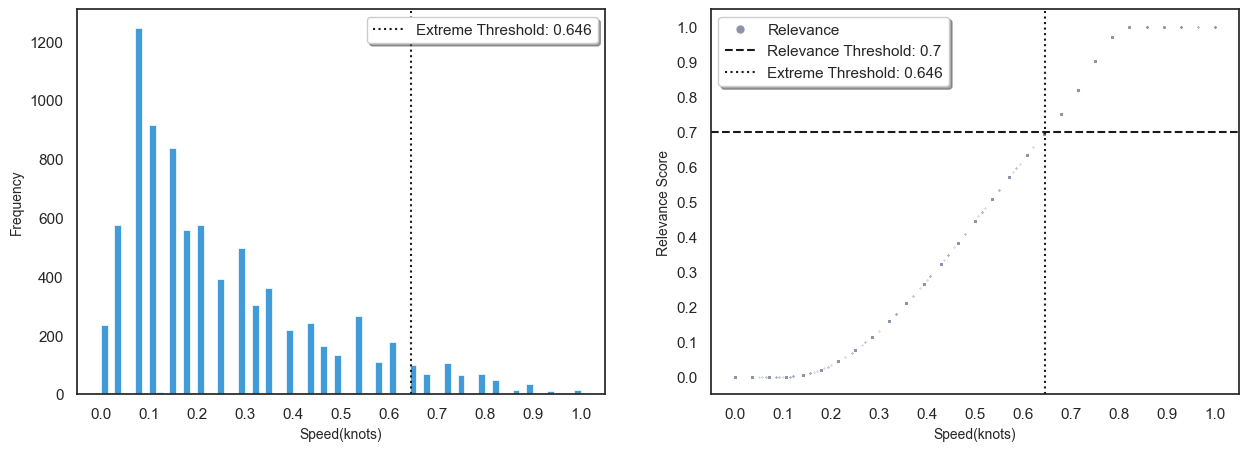

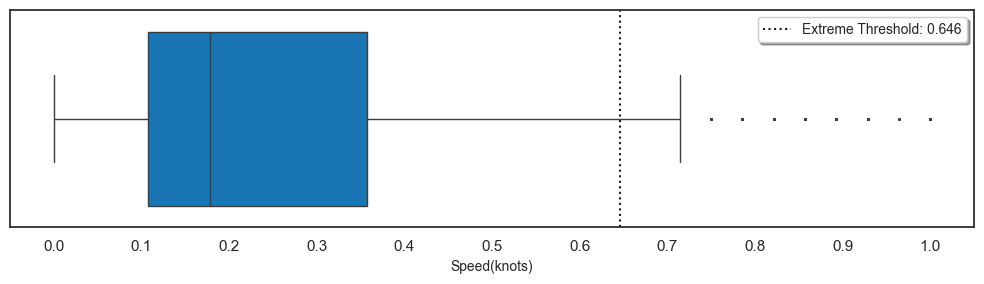

In [7]:
#Uncomment if you want to change stuff in plt_utils mid-session
import plt_utils as pu
importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)

#pu.PlotScaledData(data, TVAR)

r_Y_plot = RELEVANCE_FUNCTION.__call__(all_train_targets, combine=COMBINE) #relevance for plotting
k_Y_plot = [val >= RELEVANCE_THRESHOLD for val in r_Y_plot]
r_Y_plot = np.array(r_Y_plot)
k_Y_plot = np.array(k_Y_plot)

pu.PlotRelevance(all_train_targets, r_Y_plot, RELEVANCE_THRESHOLD, EXTREMES_THRESHOLD, TVAR, DATA_NAME)

#pu.PlotCaseWeightSurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)
#pu.PlotUtilitySurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)

#pu.PlotBins(all_train_targets,k_Y_plot,EXTREMES_THRESHOLD, TVAR, DATA_NAME)
pu.PlotBins(all_train_targets[3000:4000],k_Y_plot[3000:4000],EXTREMES_THRESHOLD, TVAR, DATA_NAME)

# **Resampling**

In [7]:
RES_STRATS = ["SMOTER_regular", "SMOTER_bin","GAN_CNN", "GAN_FNN"]#, "SMOTER_bin_t", "SMOTER_bin_r", "SMOTER_bin_tr", "GAN_CNN", "GAN_FNN"]

**Define GAN Models**

In [8]:
import GAN as gmod
importlib.reload(gmod)

n_gan_epochs = 1 #101
gan_batch_size = 128

CNN_GENS=None; CNN_DISCS=None; FNN_GENS=None; FNN_DISC=None

if "GAN_CNN" in RES_STRATS:
    CNN_GENS, CNN_DISCS = gmod.getGAN(k_Xex,GAN_CNN_DIR, "CNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)
if "GAN_FNN" in RES_STRATS:
    FNN_GENS, FNN_DISCS = gmod.getGAN(k_Xex,GAN_FNN_DIR, "FNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)

RECORDER.save_param_dict({"GAN":{"nEpochs":n_gan_epochs,"batchSize": gan_batch_size}})
print("$$$$ Finished training GANs $$$$")

LOG: 17:26:05:015 Training CNN GAN with 1 epochs


  0%|          | 0/4 [00:00<?, ?it/s]

Step 1: Generator loss: 1.4254586696624756, discriminator loss: 1.3827202320098877
Step 2: Generator loss: 0.6778864860534668, discriminator loss: 0.6963586807250977
Step 3: Generator loss: 0.6596747040748596, discriminator loss: 0.6973763704299927
LOG: 17:26:13:971 Training FNN GAN with 1 epochs


  0%|          | 0/4 [00:00<?, ?it/s]

Step 1: Generator loss: 1.4034860134124756, discriminator loss: 1.383560061454773
Step 2: Generator loss: 0.7010051012039185, discriminator loss: 0.6913080811500549
Step 3: Generator loss: 0.7005086541175842, discriminator loss: 0.6913813352584839
$$$$ Finished training GANs $$$$


In [9]:
import SMOTER as smtr
importlib.reload(smtr)

#import GAN as gmod
#importlib.reload(gmod)

K_SMOTE_NEIGHBORS = 3

def run_resampling(k_x, k_y, r_y, res_strats, relevance_function, relevance_threshold, combine):
    resampling_results = {}    
    _, orig_rels, orig_coms = smtr.countRelVsCom(k_x[:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    print(f"need to gen {orig_coms - orig_rels} new rares ontop of current {orig_rels} rares to meet {orig_coms} coms")
    #Perform each variation of each resampling approach
    if "SMOTER_bin" in res_strats:
        resampling_results['SMOTER_bin'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS)
        RECORDER.log_print(f"Finished SMOTER_bin resample")
    if "SMOTER_bin_t" in res_strats:
        resampling_results["SMOTER_bin_t"] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_t resample")
    if "SMOTER_bin_r" in res_strats:
        resampling_results['SMOTER_bin_r'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=False, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_r resample")
    if "SMOTER_bin_tr" in res_strats:
        resampling_results['SMOTER_bin_tr'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_tr resample")
    #We want all the resampling approaches to return the same number of relevance and common cases:
    _, num_rel, num_com = smtr.countRelVsCom(resampling_results['SMOTER_bin'][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    #print(f"num relevance that reg approach is trying to match {num_rel}")
    if "GAN_CNN" in res_strats:
        for key, gen in CNN_GENS.items():
            #resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "CNN") #for testing
            resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "CNN")
            RECORDER.log_print(f"Finished GAN_CNN_e{key}")
    if "GAN_FNN" in res_strats:
        for key, gen in FNN_GENS.items():
            #resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "FNN") #for testing
            resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "FNN")
            RECORDER.log_print(f"Finished GAN_FNN_e{key}")
        
    if "SMOTER_regular" in res_strats:
        resampling_results['SMOTER_regular'], yyyy = smtr.regularResample(k_x, k_y, orig_coms, num_com, K_SMOTE_NEIGHBORS)
        RECORDER.log_print("Finished SMOTER_regular")
    strat_meta = [['Resampling Method','Num Relevant','Num Common','Total']]
    for strat in resampling_results.keys():
        tot, num_rel, num_com = smtr.countRelVsCom(resampling_results[strat][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
        tab_row = [strat,str(num_rel),str(num_com),str(tot)]
        strat_meta.append(tab_row)
    tab_row = ["no_resample",str(orig_rels),str(orig_coms),str(orig_rels+orig_coms)]
    strat_meta.append(tab_row)
    
    RECORDER.log_print("Resampled sizes: \n"+tabulate(strat_meta,headers='firstrow',tablefmt='grid'))
    #RECORDER.save_sample_results_step(resampling_results, N_STEPS_IN, N_FVARS, FVARS, TVAR)
    RECORDER.save_param_dict({"SMOTE":{"kNeighbors":K_SMOTE_NEIGHBORS}})
    
    return resampling_results


#(i moved where we define RES_STRATS to be before we train the GANS)
resampling_results = run_resampling(k_X, k_Y, r_Y, RES_STRATS, RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, COMBINE)

need to gen 7526 new rares ontop of current 436 rares to meet 7962 coms
LOG: 17:26:31:625 Finished SMOTER_bin resample
LOG: 17:26:50:712 Finished GAN_CNN_e0

LOG: 17:26:50:995 Finished GAN_FNN_e0

LOG: 17:26:51:120 Finished SMOTER_regular

LOG: 17:26:51:187 Resampled sizes: 
+---------------------+----------------+--------------+---------+
| Resampling Method   |   Num Relevant |   Num Common |   Total |
+=====================+================+==============+=========+
| SMOTER_bin          |           7939 |         7962 |   15901 |
+---------------------+----------------+--------------+---------+
| GAN_CNN_e0          |           7535 |         8366 |   15901 |
+---------------------+----------------+--------------+---------+
| GAN_FNN_e0          |            544 |        15357 |   15901 |
+---------------------+----------------+--------------+---------+
| SMOTER_regular      |           7962 |         7962 |   15924 |
+---------------------+----------------+--------------+---------

#### Plot Resampling Results

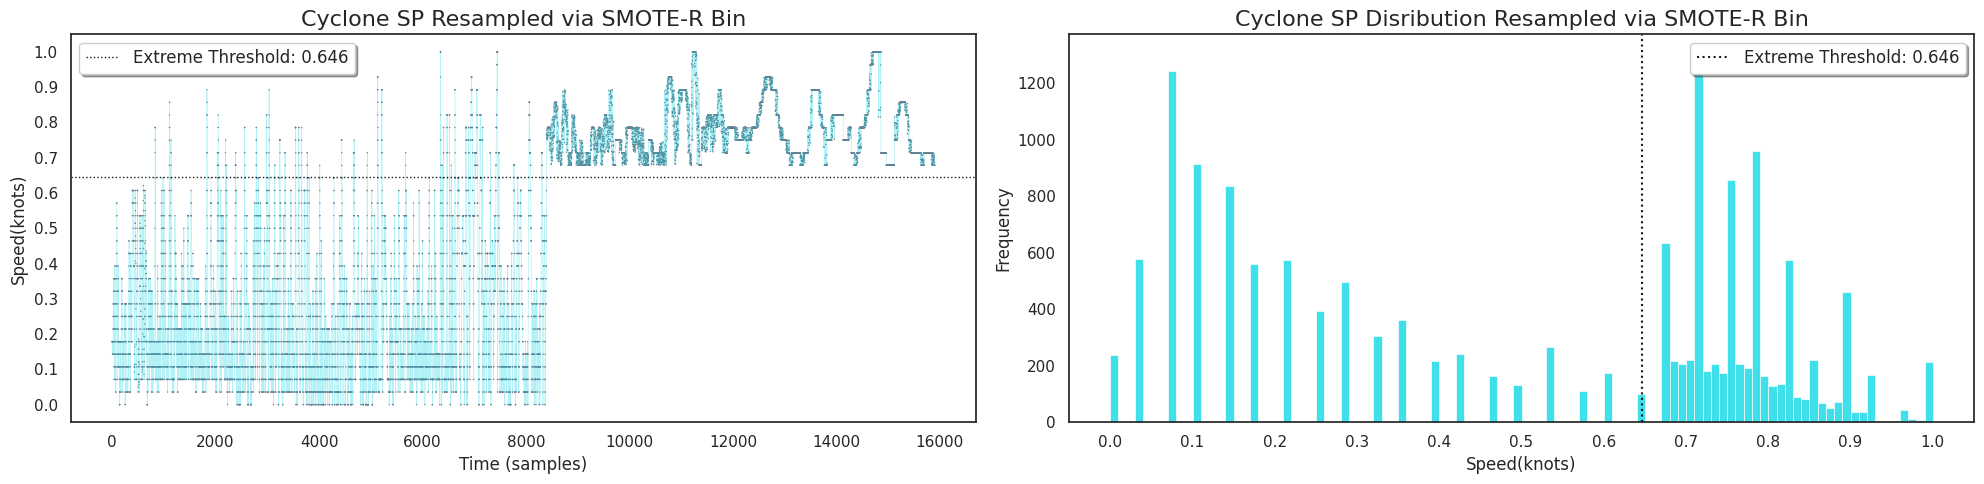

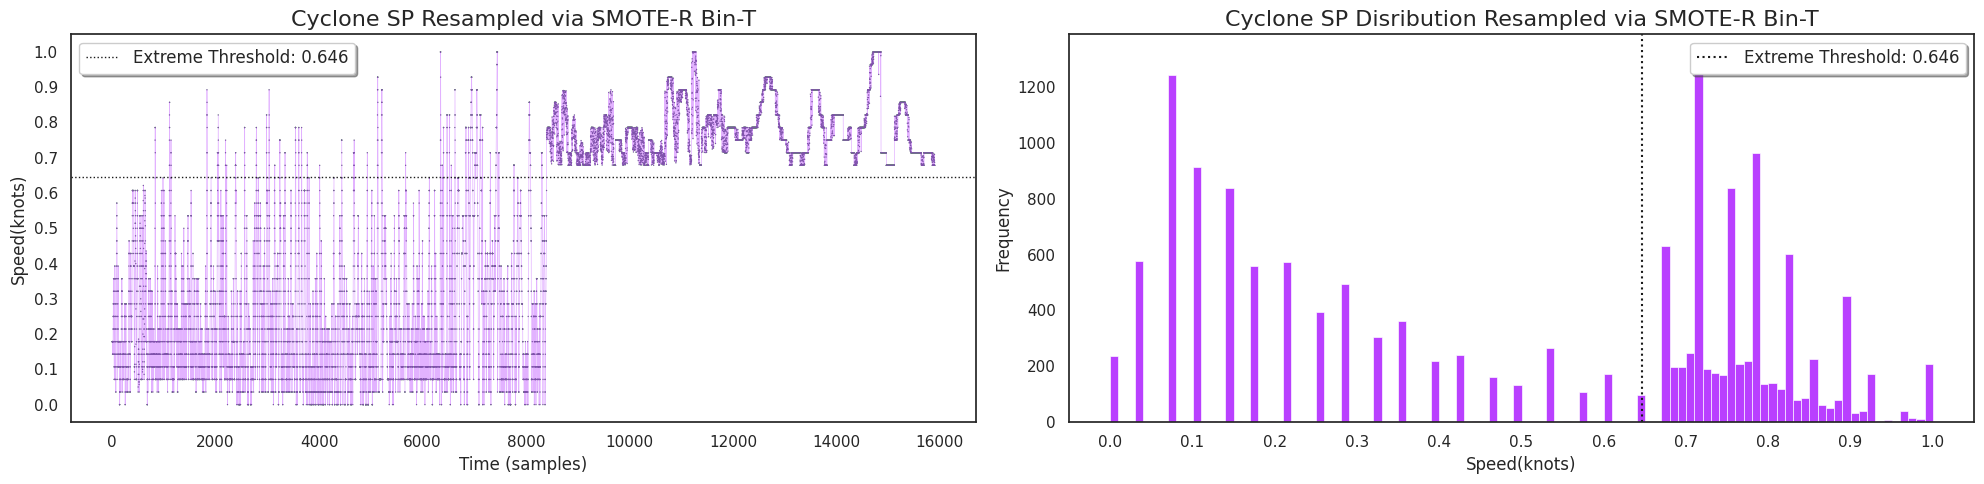

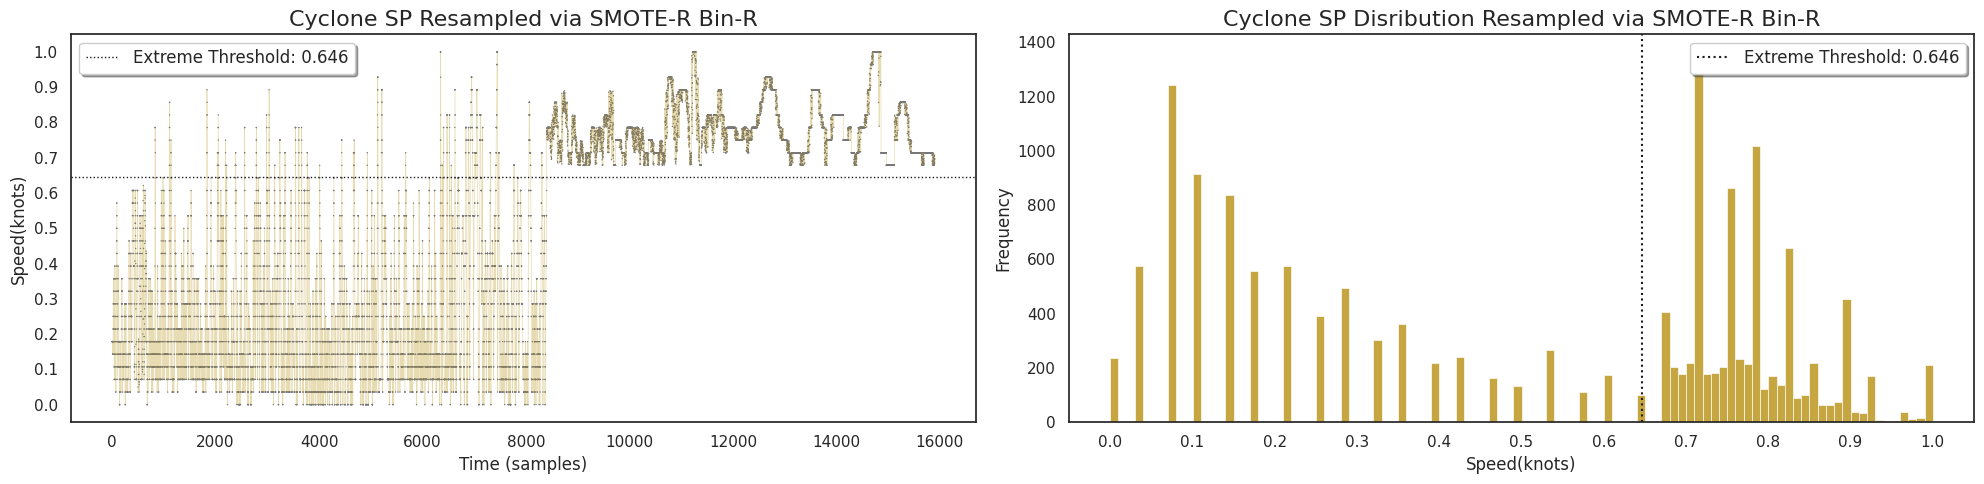

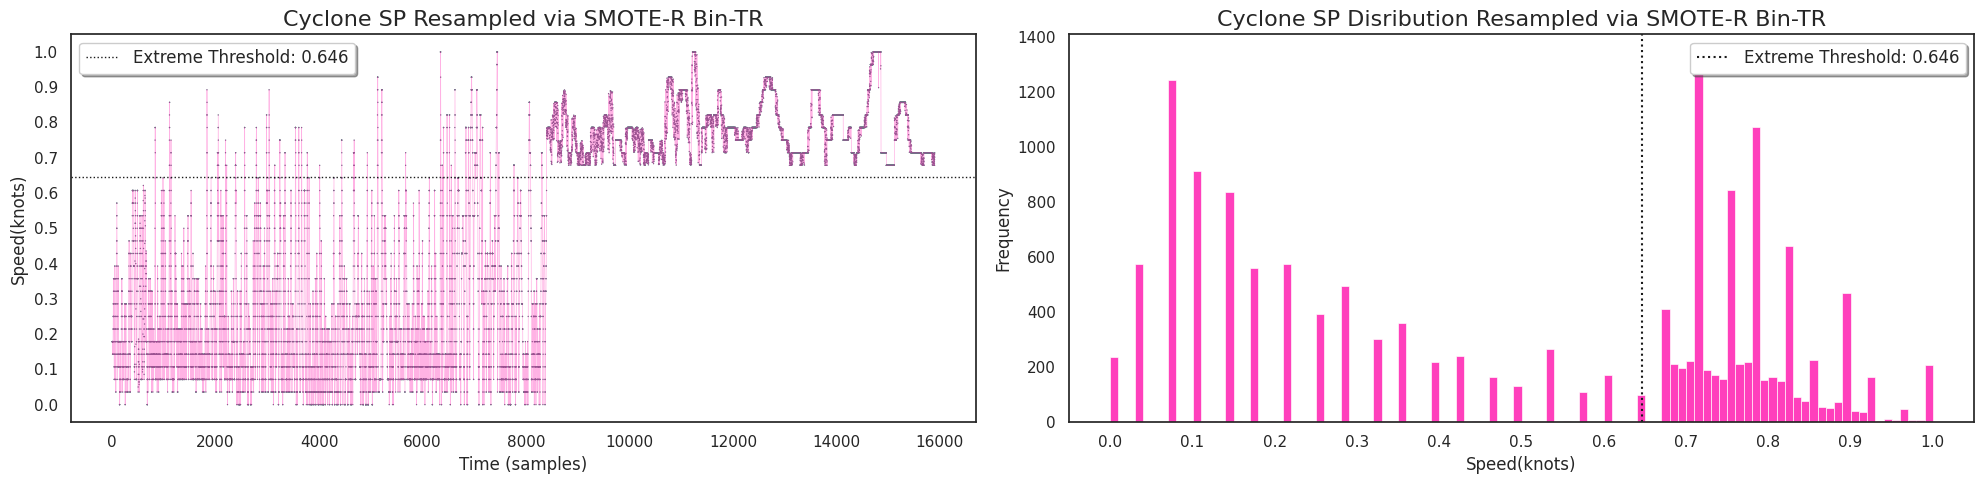

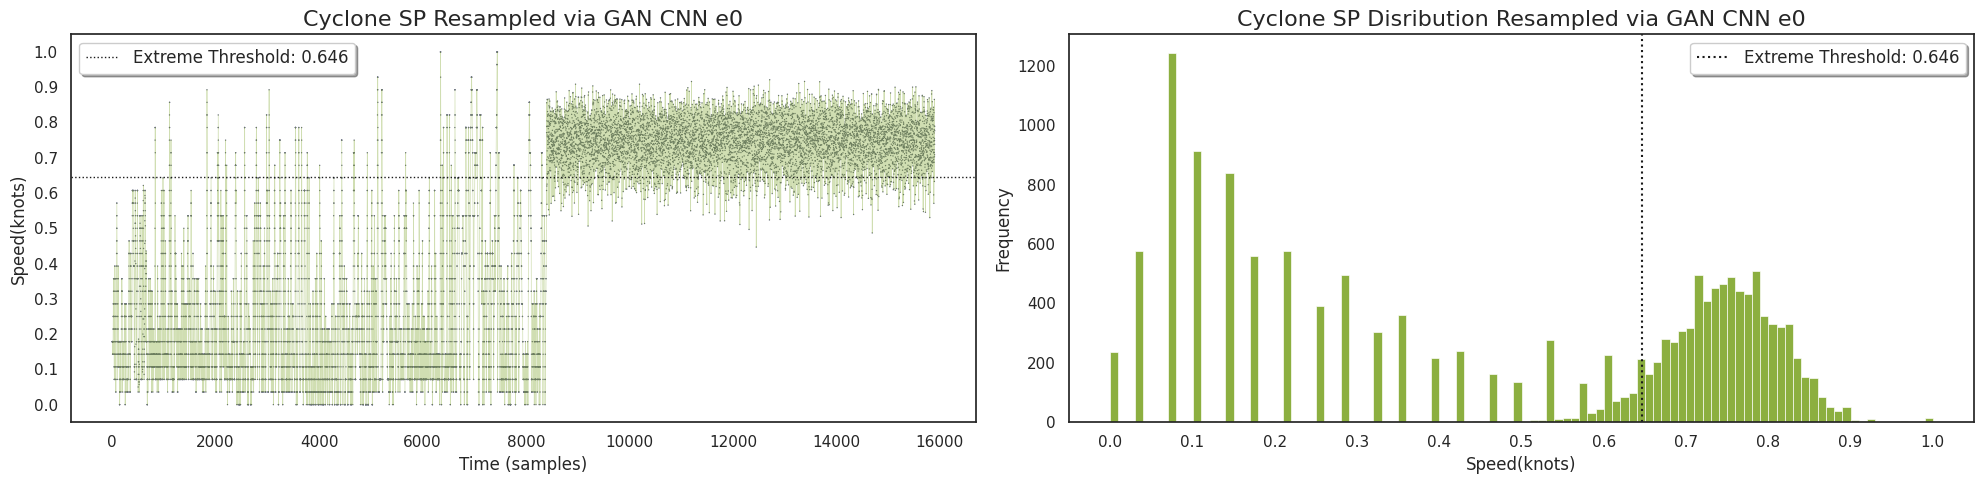

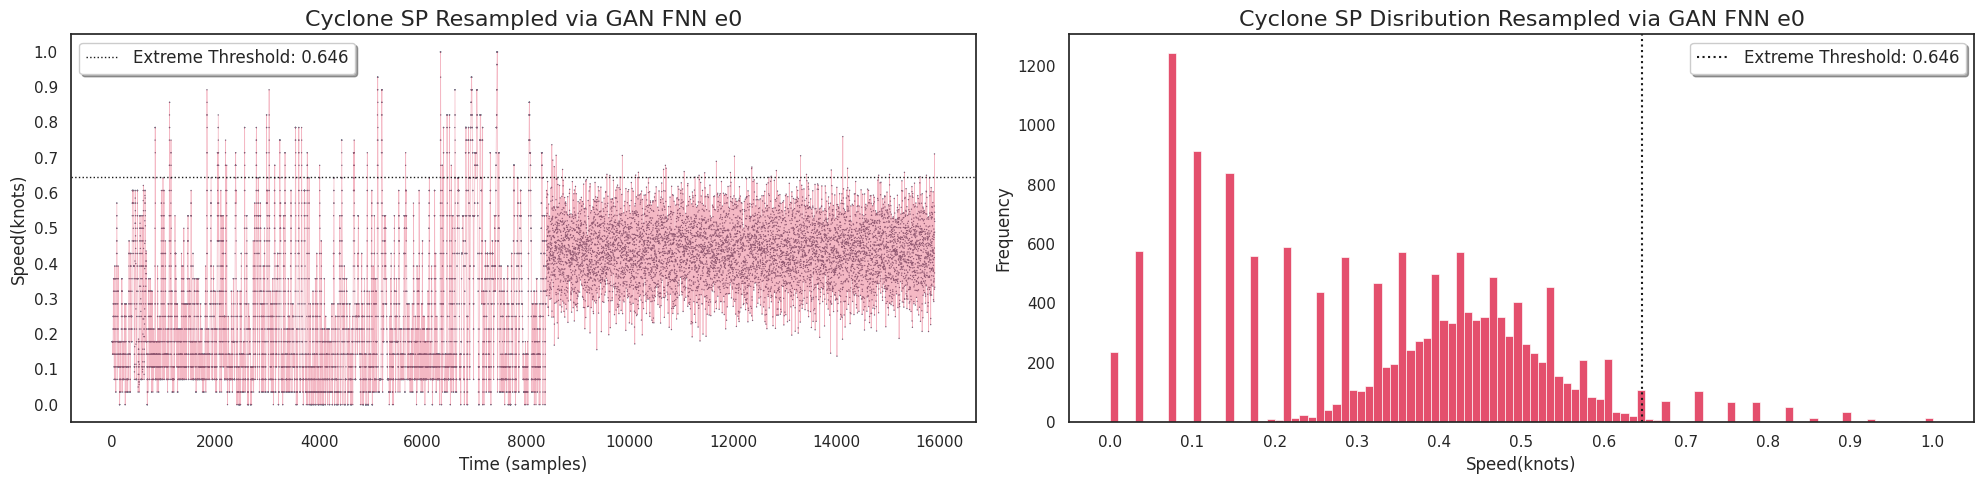

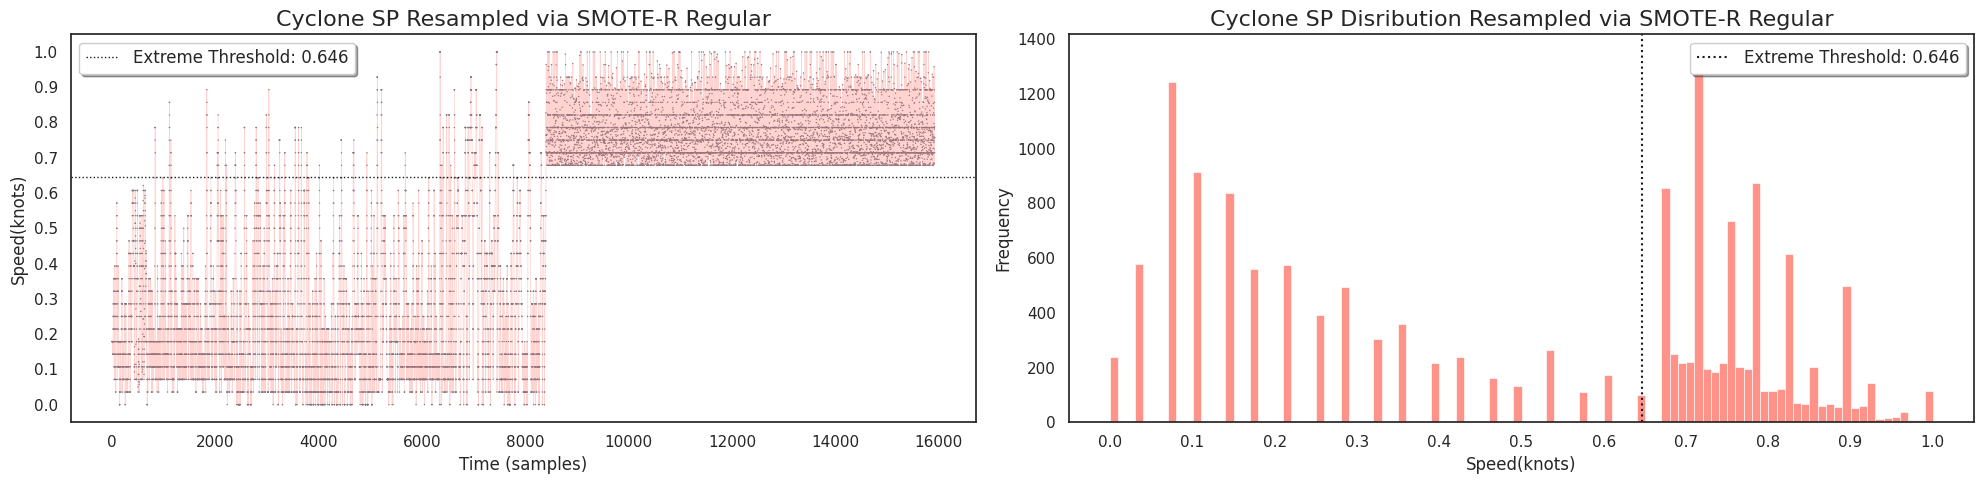

In [48]:
#import plt_utils as pu
#importlib.reload(pu)
#only plots first step out in each embedded
pu.PlotResampledResults(resampling_results, k_X.shape[0], N_STEPS_OUT,EXTREMES_THRESHOLD, TVAR, DATA_NAME)

### Remove Bad GANs

Save time training the forecasters by removing GANs that will clearly generate bad results

In [50]:
all_resampling_results = resampling_results.copy() #save a copy just incase
to_delete = []#['GAN_CNN_e0', 'GAN_CNN_e10', 'GAN_CNN_e20', 'GAN_CNN_e30', 'GAN_CNN_e60', 'GAN_CNN_e70', 'GAN_CNN_e80', 'GAN_CNN_e90', 'GAN_CNN_e100', 'GAN_FNN_e0', 'GAN_FNN_e10', 'GAN_FNN_e20', 'GAN_FNN_e30', 'GAN_FNN_e40', 'GAN_FNN_e50', 'GAN_FNN_e60', 'GAN_FNN_e70', 'GAN_FNN_e80', 'GAN_FNN_e90'] #['GAN_CNN_e10'] #specify resampling results to delete from the dictionary
print(resampling_results.keys())
for d in to_delete:
    del resampling_results[d]
print(resampling_results.keys())

dict_keys(['SMOTER_bin', 'SMOTER_bin_t', 'SMOTER_bin_r', 'SMOTER_bin_tr', 'GAN_FNN_e0', 'SMOTER_regular'])
dict_keys(['SMOTER_bin', 'SMOTER_bin_t', 'SMOTER_bin_r', 'SMOTER_bin_tr', 'GAN_FNN_e0', 'SMOTER_regular'])


# **Running Forecasting Experiments**

**Init Evaluator object for model eval metrics**

In [19]:
import evaluator as ev
importlib.reload(ev)

#NOTE: evaler_params must include CaseWeight else errors in MODEL_LSTM
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "SER": {},
                     "Utility": {'m':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {},
                     "FScore": {'beta':0.5},
                     #"RelevanceROC": {},
                   }
EVALERS = {}
for f in FORECASTERS:
    EVALERS[f] = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

#EVALER = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)
RECORDER.save_param_dict({"Evaluator":evaluator_params})

**Train and evaluate an LSTM for each resampling strategy**

In [20]:
NUM_EXPERIMENTS = 10

def main(time_step, X_train, X_test, Y_train, Y_test, resampling_results, evalers, recorder, train_params):   
    recorder.log_print(f"Starting forecasting experiments with num_exps: {train_params['num_exp']} and epochs: {train_params['epochs']}")
    recorder.save_param_dict({"Forecasting":{"NumExp":train_params['num_exp'], "nEpochs": train_params['epochs'], "hidden":train_params['hidden']}})
    
    forecast_results = {}
    for f in FORECASTERS:
        print(f"############## no_resample : {f} ##############")
        if f == "BD_LSTM":
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_BD_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
        else:
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_CONV_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
    
        results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_train,'Y_train':Y_train,'model':best_model}
        forecast_results[f] = {}
        forecast_results[f]['no_resample'] = results
    
    
    for key in resampling_results.keys():
        res = resampling_results[key]
        X_res = res[:,:(N_STEPS_IN*N_FVARS)]
        X_res = X_res.reshape((X_res.shape[0],N_STEPS_IN,N_FVARS))
        Y_res = res[:,(N_STEPS_IN*N_FVARS):]
        for f in FORECASTERS:
            print(f"############## {key} : {f} ##############")
            if f == "BD_LSTM":
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_BD_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
            else:
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_CONV_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
        
            results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_res,'Y_train':Y_res,'model':best_model}
            forecast_results[f][key] = results
    
    return forecast_results

TRAIN_PARAMS = {
        'num_exp': NUM_EXPERIMENTS, 
        'n_steps_in': N_STEPS_IN,
        'n_steps_out': N_STEPS_OUT,
        'epochs': 10,
        'hidden': 100,
        'forecast_dir': FORECAST_DIR,
        'n_fvars': N_FVARS
    }

forecast_results = main(N_STEPS_IN, X_train, X_test, Y_train, Y_test, resampling_results, EVALERS, RECORDER, TRAIN_PARAMS)

print("$$$$ FINISHED FORECASTING EXPERIMENTS $$$$")

LOG: 17:42:21:571 Starting forecasting experiments with num_exps: 10 and epochs: 10

############## no_resample : BD_LSTM ##############
====== Running BD-LSTM Model ======
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirecti  (None, 5, 200)           81600     
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 200)              240800    
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 323,405
Trainable params: 323,405
Non-trainable params: 0
_________________________________________________________________
LOG: 1

## *SAVE EVALER RESULTS ---- DON'T FORGET*

In [21]:
for f in FORECASTERS:
    RECORDER.save_all_evaler_exps(EVALERS[f].getResultsDf(), f)
#    RECORDER.save_summary_evaler(f)

In [30]:
df2 = EVALERS["BD_LSTM"].getResultsDf()

# 筛选包含 RMSE, RMSE-R, caseweight, SER5% 的列
cols = df2.filter(regex="^RMSE|CaseWeight|SER.*5").columns.tolist()

# 加入 Res 列用于分组
ser_rmse_df = df2[["Res"] + cols]

# 对包含数组的单元取平均值（如 ndarray）
ser_rmse_df[cols] = ser_rmse_df[cols].applymap(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# 分组计算均值与标准差
grouped = ser_rmse_df.groupby("Res")
mean_df = grouped.mean().round(4)
std_df = grouped.std().round(4)

# 分开输出
mean_df

RMSE_Train  RMSERare_Train  CaseWeight_Train  RMSE_Test  \
Res                                                                       
GAN_CNN_e0          0.0918          0.0734            0.0088     0.0935   
GAN_FNN_e0          0.1049          0.2247            0.0121     0.1156   
SMOTER_bin          0.1033          0.0719            0.0113     0.0876   
SMOTER_regular      0.0943          0.0632            0.0092     0.0832   
no_resample         0.0865          0.1160            0.0149     0.0696   

                RMSERare_Test  CaseWeight_Test  SER5%_Train  SER25%_Train  \
Res                                                                         
GAN_CNN_e0             0.0973           0.0138       0.1335        0.0910   
GAN_FNN_e0             0.2181           0.0201       0.1560        0.1100   
SMOTER_bin             0.0649           0.0084       0.1151        0.1180   
SMOTER_regular         0.0632           0.0081       0.1172        0.1088   
no_resample            0.0766           0.0060       0.1607        0.1314   

                SER50%_Train  SER75%_Train  SER5%_Test  SER25%_Test  \
Res                                                                   
GAN_CNN_e0            0.1005        0.1006      0.1121       0.1170   
GAN_FNN_e0            0.1028        0.1115      0.1854       0.1416   
SMOTER_bin            0.1151        0.1189      0.0840       0.0985   
SMOTER_regular        0.1049        0.1091      0.0978       0.0975   
no_resample           0.1148        0.0955      0.0854       0.0813   

                SER50%_Test  SER75%_Test  
Res                                       
GAN_CNN_e0           0.1127       0.1048  
GAN_FNN_e0           0.1332       0.1272  
SMOTER_bin           0.1007       0.0969  
SMOTER_regular       0.0977       0.0922  
no_resample          0.0801       0.0780

In [16]:
df = EVALERS["Conv_LSTM"].getResultsDf()

# 只选 SER 和 RMSE_Test 相关列
cols = df.filter(like="SER").columns.tolist() + df.filter(like="RMSE_Test").columns.tolist()
ser_rmse_df = df[["Res"] + cols]  # ⬅️ 加上 Res 列

# 展开 SER 中的 array，取均值
ser_rmse_df[cols] = ser_rmse_df[cols].applymap(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# 按 Res 分组，计算均值和标准差
grouped = ser_rmse_df.groupby("Res")
mean_df = grouped.mean()
std_df = grouped.std()

# 拼成 "均值 ± 标准差" 格式
summary = mean_df.round(4).astype(str) + " ± " + std_df.round(4).astype(str)
summary


RMSERare_Train  SER_Train    RMSERare_Test   SER_Test  \
Res                                                                      
SMOTER_bin      0.0749 ± 0.0197  nan ± nan  0.0683 ± 0.0115  nan ± nan   
SMOTER_regular  0.0618 ± 0.0097  nan ± nan  0.0646 ± 0.0048  nan ± nan   
no_resample     0.1258 ± 0.0557  nan ± nan  0.0909 ± 0.0403  nan ± nan   

                    SER1%_Train      SER2%_Train      SER5%_Train  \
Res                                                                 
SMOTER_bin       0.1048 ± 0.045   0.1048 ± 0.045  0.1016 ± 0.0376   
SMOTER_regular  0.0995 ± 0.0129  0.0995 ± 0.0129  0.0999 ± 0.0133   
no_resample     0.1478 ± 0.0446  0.1474 ± 0.0224    0.1374 ± 0.02   

                   SER10%_Train     SER25%_Train     SER50%_Train  \
Res                                                                 
SMOTER_bin         0.1 ± 0.0299  0.1077 ± 0.0155   0.1117 ± 0.012   
SMOTER_regular  0.0987 ± 0.0115   0.101 ± 0.0106   0.1016 ± 0.014   
no_resample     0.1274 ± 0.0197  0.1208 ± 0.0223  0.1095 ± 0.0213   

                   SER75%_Train       SER1%_Test       SER2%_Test  \
Res                                                                 
SMOTER_bin      0.1154 ± 0.0203  0.0626 ± 0.0109  0.0692 ± 0.0112   
SMOTER_regular  0.1093 ± 0.0336  0.0732 ± 0.0105   0.079 ± 0.0116   
no_resample     0.0898 ± 0.0219  0.0783 ± 0.0278  0.0843 ± 0.0283   

                     SER5%_Test      SER10%_Test      SER25%_Test  \
Res                                                                 
SMOTER_bin      0.0749 ± 0.0123  0.0842 ± 0.0074  0.0857 ± 0.0111   
SMOTER_regular  0.0987 ± 0.0187  0.1011 ± 0.0103   0.093 ± 0.0204   
no_resample     0.0813 ± 0.0283   0.0837 ± 0.025  0.0836 ± 0.0224   

                    SER50%_Test      SER75%_Test        RMSE_Test  
Res                                                                
SMOTER_bin      0.0876 ± 0.0204  0.0875 ± 0.0268   0.081 ± 0.0297  
SMOTER_regular  0.0937 ± 0.0423   0.0947 ± 0.054    0.089 ± 0.059  
no_resample     0.0822 ± 0.0205   0.0797 ± 0.018  0.0712 ± 0.0164

In [17]:
df2 = EVALERS["BD_LSTM"].getResultsDf()

# 只选 SER 和 RMSE_Test 相关列
cols = df2.filter(like="SER").columns.tolist() + df2.filter(like="RMSE_Test").columns.tolist()
ser_rmse_df = df2[["Res"] + cols]  # ⬅️ 加上 Res 列

# 展开 SER 中的 array，取均值
ser_rmse_df[cols] = ser_rmse_df[cols].applymap(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# 按 Res 分组，计算均值和标准差
grouped = ser_rmse_df.groupby("Res")
mean_df = grouped.mean()
std_df = grouped.std()

# 拼成 "均值 ± 标准差" 格式
summary2 = mean_df.round(4).astype(str) + " ± " + std_df.round(4).astype(str)
summary2


RMSERare_Train  SER_Train    RMSERare_Test   SER_Test  \
Res                                                                      
SMOTER_bin      0.0762 ± 0.0117  nan ± nan  0.0707 ± 0.0149  nan ± nan   
SMOTER_regular    0.0594 ± 0.01  nan ± nan   0.0642 ± 0.006  nan ± nan   
no_resample     0.1235 ± 0.0253  nan ± nan  0.0949 ± 0.0266  nan ± nan   

                    SER1%_Train      SER2%_Train      SER5%_Train  \
Res                                                                 
SMOTER_bin       0.105 ± 0.0415   0.105 ± 0.0415  0.1059 ± 0.0421   
SMOTER_regular  0.1053 ± 0.0115  0.1053 ± 0.0115  0.1064 ± 0.0119   
no_resample     0.1419 ± 0.0627  0.1464 ± 0.0344  0.1417 ± 0.0198   

                   SER10%_Train     SER25%_Train     SER50%_Train  \
Res                                                                 
SMOTER_bin      0.1031 ± 0.0389  0.1098 ± 0.0181  0.1116 ± 0.0104   
SMOTER_regular   0.1041 ± 0.008  0.0993 ± 0.0121  0.0991 ± 0.0116   
no_resample     0.1319 ± 0.0169  0.1235 ± 0.0165  0.1097 ± 0.0155   

                   SER75%_Train       SER1%_Test       SER2%_Test  \
Res                                                                 
SMOTER_bin      0.1196 ± 0.0225  0.0744 ± 0.0368  0.0765 ± 0.0264   
SMOTER_regular  0.1068 ± 0.0247  0.0822 ± 0.0144  0.0877 ± 0.0137   
no_resample     0.0899 ± 0.0133   0.0985 ± 0.049  0.0934 ± 0.0312   

                     SER5%_Test      SER10%_Test      SER25%_Test  \
Res                                                                 
SMOTER_bin       0.0839 ± 0.012  0.0925 ± 0.0067  0.0968 ± 0.0149   
SMOTER_regular  0.1048 ± 0.0147  0.1079 ± 0.0095  0.1001 ± 0.0077   
no_resample     0.0892 ± 0.0173  0.0892 ± 0.0099  0.0844 ± 0.0075   

                    SER50%_Test      SER75%_Test        RMSE_Test  
Res                                                                
SMOTER_bin      0.0993 ± 0.0319  0.0981 ± 0.0411  0.0903 ± 0.0445  
SMOTER_regular  0.0994 ± 0.0256  0.0979 ± 0.0382  0.0903 ± 0.0431  
no_resample      0.083 ± 0.0087  0.0802 ± 0.0085  0.0718 ± 0.0081

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def compute_rmse_metrics(forecast_results, relevance_fn):
    records = []

    for model in forecast_results:
        for method in forecast_results[model]:
            data = forecast_results[model][method]

            # 取最后一个时间步作为目标
            y_true_train = data["Y_train"][:, -1]
            y_pred_train = data["predict_train"][:, -1]
            y_true_test = data["Y_test"][:, -1]
            y_pred_test = data["predict_test"][:, -1]

            # relevance mask（高相关度样本）
            y_train_relevance = relevance_fn(y_true_train)
            y_test_relevance = relevance_fn(y_true_test)

            mask_train = y_train_relevance > 0.7
            mask_test = y_test_relevance > 0.7

            # 分别计算4个RMSE相关指标
            rmser_train = mean_squared_error(y_true_train[mask_train], y_pred_train[mask_train], squared=False)
            rmser_test = mean_squared_error(y_true_test[mask_test], y_pred_test[mask_test], squared=False)
            rmse_train = mean_squared_error(y_true_train, y_pred_train, squared=False)
            rmse_test = mean_squared_error(y_true_test, y_pred_test, squared=False)

            records.append({
                "Model": model,
                "Method": method,
                "train RMSE-R": rmser_train,
                "test RMSE-R": rmser_test,
                "train RMSE": rmse_train,
                "test RMSE": rmse_test
            })

    return pd.DataFrame(records)
df_metrics = compute_rmse_metrics(forecast_results, RELEVANCE_FUNCTION)
display(df_metrics)

KeyError: 'Y_test'

In [21]:
import pandas as pd

# 假设你的 DataFrame 名为 df
grouped = df.groupby(['Exp', 'Res'])[
    ['RMSERare_Train', 'RMSERare_Test', 'RMSE_Train', 'RMSE_Test']
].mean().reset_index()

# 重命名列，让输出更清晰
grouped.columns = ['Model', 'Method', 'Train RMSE-R', 'Test RMSE-R', 'Train RMSE', 'Test RMSE']

# 显示结果
display(grouped)


Model          Method                                       Train RMSE-R  \
0       1      SMOTER_bin  [0.07093089207492602, 0.06957181965505035, 0.0...   
1       1  SMOTER_regular  [0.031819176987909155, 0.053040812858198096, 0...   
2       1     no_resample  [0.056295861690306544, 0.08182926342983089, 0....   
3       2      SMOTER_bin  [0.04044782134346828, 0.05267704915781867, 0.0...   
4       2  SMOTER_regular  [0.031370964892464326, 0.0521059827372956, 0.0...   
5       2     no_resample  [0.0529748149920244, 0.07134325215693371, 0.09...   
6       3      SMOTER_bin  [0.03630542074086461, 0.052635237327041756, 0....   
7       3  SMOTER_regular  [0.025449942887033578, 0.04262987220341002, 0....   
8       3     no_resample  [0.047794971238295354, 0.08773290498565015, 0....   
9       4      SMOTER_bin  [0.03730826726593284, 0.05286598567636448, 0.0...   
10      4  SMOTER_regular  [0.026316752383693517, 0.041786474343591985, 0...   
11      4     no_resample  [0.0637760537745852, 0.09328134916449612, 0.12...   
12      5      SMOTER_bin  [0.042796179401180225, 0.054303004663829646, 0...   
13      5  SMOTER_regular  [0.025518350129955316, 0.04054724137467535, 0....   
14      5     no_resample  [0.06367113324983373, 0.09119335938375993, 0.1...   
15      6      SMOTER_bin  [0.04572875895567449, 0.053070421241947344, 0....   
16      6  SMOTER_regular  [0.024344941840980988, 0.041112329438705165, 0...   
17      6     no_resample  [0.06555938609785823, 0.08285738018312336, 0.1...   
18      7      SMOTER_bin  [0.04688922973925789, 0.05466174134942683, 0.0...   
19      7  SMOTER_regular  [0.02334323901571423, 0.038297482428339635, 0....   
20      7     no_resample  [0.05548143565357462, 0.07917021838592952, 0.1...   
21      8      SMOTER_bin  [0.047955545533187705, 0.05292058369517656, 0....   
22      8  SMOTER_regular  [0.02484217732510604, 0.03748722470795892, 0.0...   
23      8     no_resample  [0.06435166680308053, 0.09583100059770641, 0.1...   
24      9      SMOTER_bin  [0.04209856938178717, 0.05356874184050589, 0.0...   
25      9  SMOTER_regular  [0.02292058162223489, 0.03851558707196219, 0.0...   
26      9     no_resample  [0.08072066297806854, 0.10797935952505662, 0.1...   
27     10      SMOTER_bin  [0.04590962011281883, 0.05254898353581632, 0.0...   
28     10  SMOTER_regular  [0.022075500107209454, 0.03732190786838691, 0....   
29     10     no_resample  [0.05970222526358672, 0.0778146272707375, 0.10...   

                                          Test RMSE-R  \
0   [0.06150909994038736, 0.0603746367122566, 0.06...   
1   [0.0344829607726698, 0.05245679424415984, 0.06...   
2   [0.04015710834142783, 0.046002055985044484, 0....   
3   [0.038491864079214136, 0.04356908132663942, 0....   
4   [0.03566785772355661, 0.05544653649627315, 0.0...   
5   [0.0430343980477456, 0.045704378054430936, 0.0...   
6   [0.03514900040198896, 0.041884005044581785, 0....   
7   [0.02953134883131718, 0.04503557263664011, 0.0...   
8   [0.040526878696282125, 0.068888507057085, 0.08...   
9   [0.03348863478368266, 0.03918230501330129, 0.0...   
10  [0.030476486740329944, 0.04251828621126245, 0....   
11  [0.061007623305515804, 0.08038105950889833, 0....   
12  [0.03931120121726406, 0.04288228988990871, 0.0...   
13  [0.03086846557599456, 0.04314989478441169, 0.0...   
14  [0.06026427112190751, 0.07754776000238653, 0.0...   
15  [0.041551282561393024, 0.04109683981929586, 0....   
16  [0.03099557123074527, 0.04497214504142298, 0.0...   
17  [0.06528634494412791, 0.07367177008185127, 0.0...   
18  [0.04244389383068945, 0.042995253624316936, 0....   
19  [0.0313549865400644, 0.04461784514071513, 0.05...   
20  [0.05343752715643975, 0.06783256367931938, 0.0...   
21  [0.04145674749621984, 0.041402956745902164, 0....   
22  [0.0333992696368197, 0.045614780941149236, 0.0...   
23  [0.058996627946242094, 0.08312153973898141, 0....   
24  [0.03798087083896568, 0.04426997006531995, 0.0...   
25  [0.032334273753990894, 0.047253556578

In [19]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def compute_rmse_metrics(forecast_results, y_train, y_train_relevance, y_test, y_test_relevance, threshold=0.7):
    rows = []

    for model in forecast_results:
        for method in forecast_results[model]:
            preds_train = forecast_results[model][method]['predict_train']
            preds_test = forecast_results[model][method]['predict_test']
            true_train = forecast_results[model][method]['Y_train']
            true_test = y_test

            # 只取最后一个预测步
            y_pred_train = preds_train[:, -1]
            y_pred_test = preds_test[:, -1]
            y_true_train = true_train[:, -1]
            y_true_test = y_test

            mask_train = y_train_relevance > threshold
            mask_test = y_test_relevance > threshold

            # 计算 RMSE-R（高相关）
            rmser_train = mean_squared_error(y_true_train[mask_train], y_pred_train[mask_train], squared=False)
            rmser_test = mean_squared_error(y_true_test[mask_test], y_pred_test[mask_test], squared=False)

            # 计算整体 RMSE
            rmse_train = mean_squared_error(y_true_train, y_pred_train, squared=False)
            rmse_test = mean_squared_error(y_true_test, y_pred_test, squared=False)

            rows.append({
                "Model": model,
                "Method": method,
                "train RMSE-R": rmser_train,
                "test RMSE-R": rmser_test,
                "train RMSE": rmse_train,
                "test RMSE": rmse_test
            })

    df_summary = pd.DataFrame(rows)
    df_summary.to_csv("overall_rmse_summary.csv", index=False)
    return df_summary

# 截取预测目标变量，必须与 predict 对齐
# 从 forecast_results 中统一提取（必须与每组 predict 对齐）
y_train_sub = {}
y_test_sub = {}

for model in forecast_results:
    y_train_sub[model] = {}
    y_test_sub[model] = {}
    for method in forecast_results[model]:
        n_train = forecast_results[model][method]['predict_train'].shape[0]
        n_test = forecast_results[model][method]['predict_test'].shape[0]
        
        y_train_sub[model][method] = forecast_results[model][method]['Y_train'][:n_train, -1]
        y_test_sub[model][method] = forecast_results[model][method]['Y_test'][:n_test, -1]

# y_train_sub = forecast_results[model][method]["Y_train"][:, -1]
# y_test_sub = Y_test[:, -1]  # 假设你有 Y_test 和 Y_test_relevance 是对齐的

y_train_relevance = RELEVANCE_FUNCTION(y_train_sub)
y_test_relevance = RELEVANCE_FUNCTION(y_test_sub)

df_metrics = compute_rmse_metrics(
    forecast_results,
    y_train_sub,
    y_train_relevance,
    y_test_sub,
    y_test_relevance
)


display(df_metrics)


KeyError: 'Y_test'

### Plot Actual vs Predicted

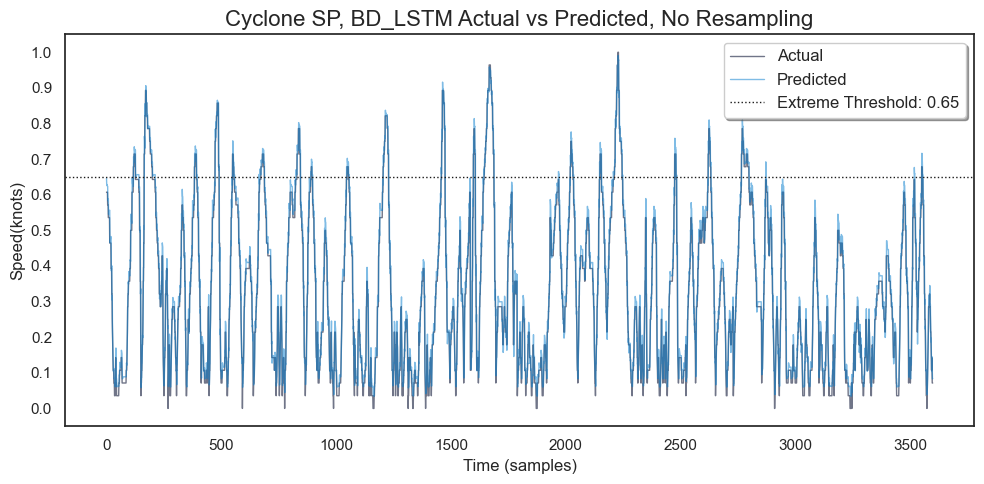

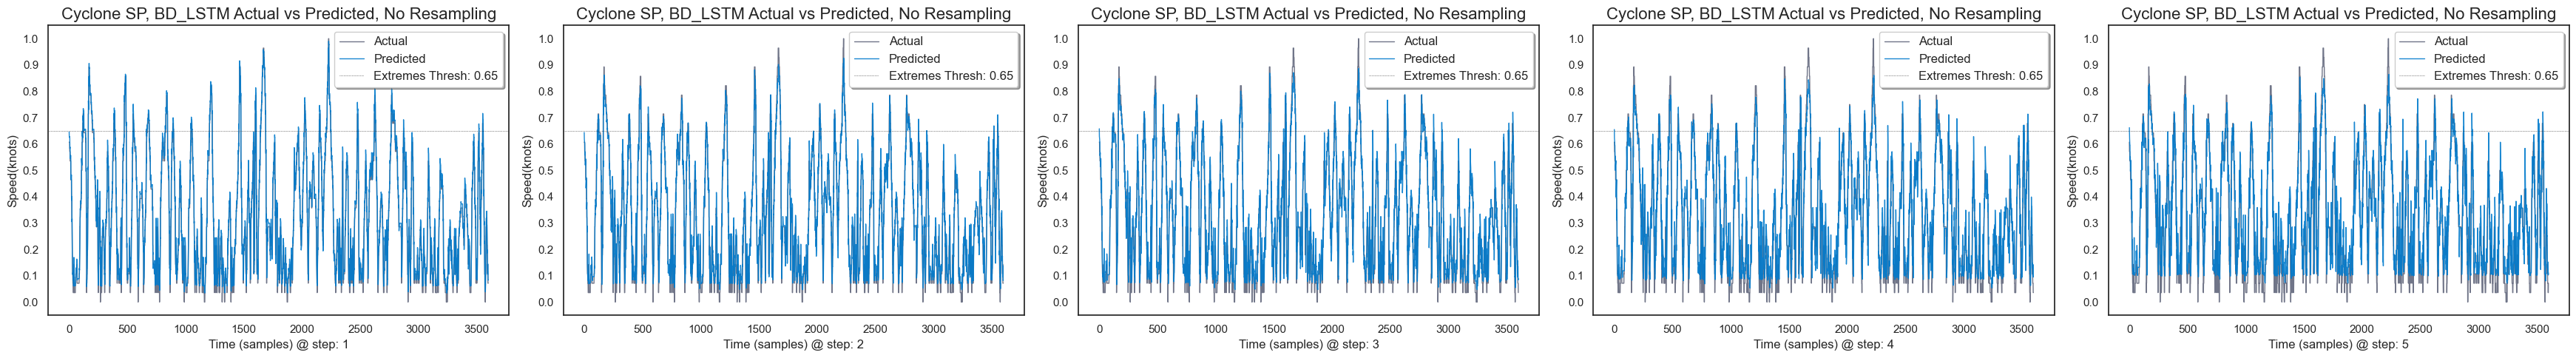

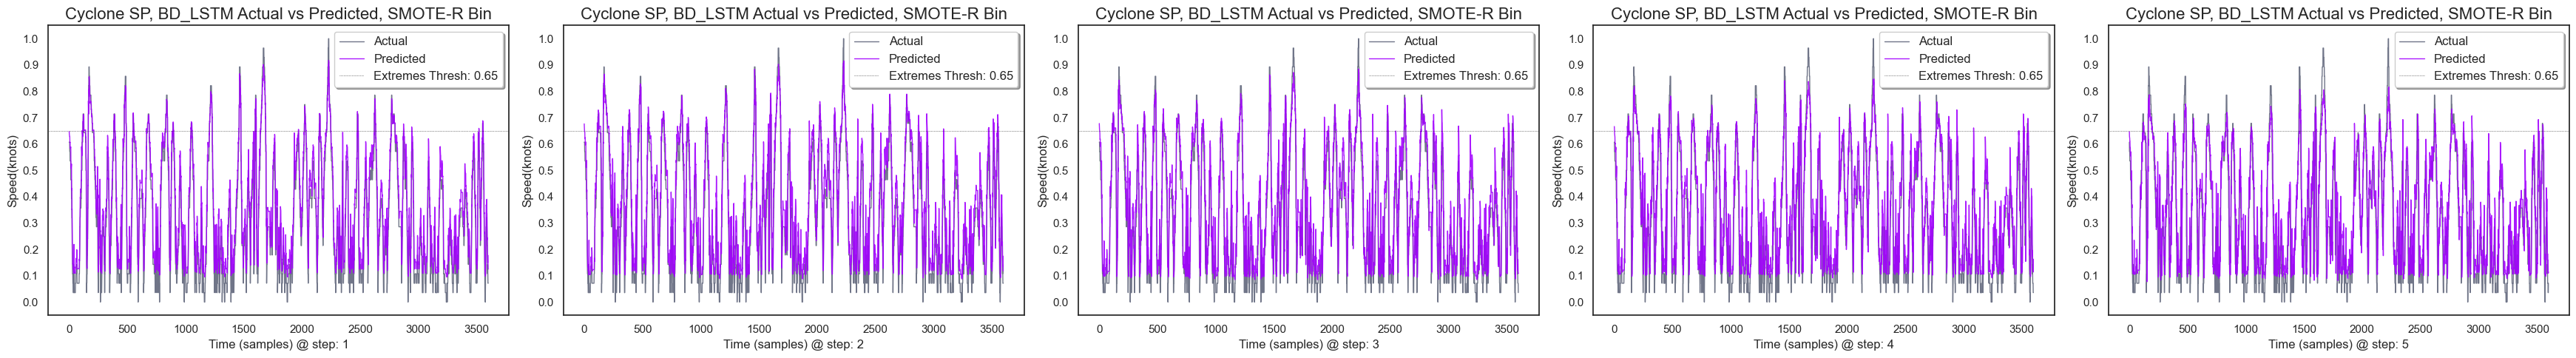

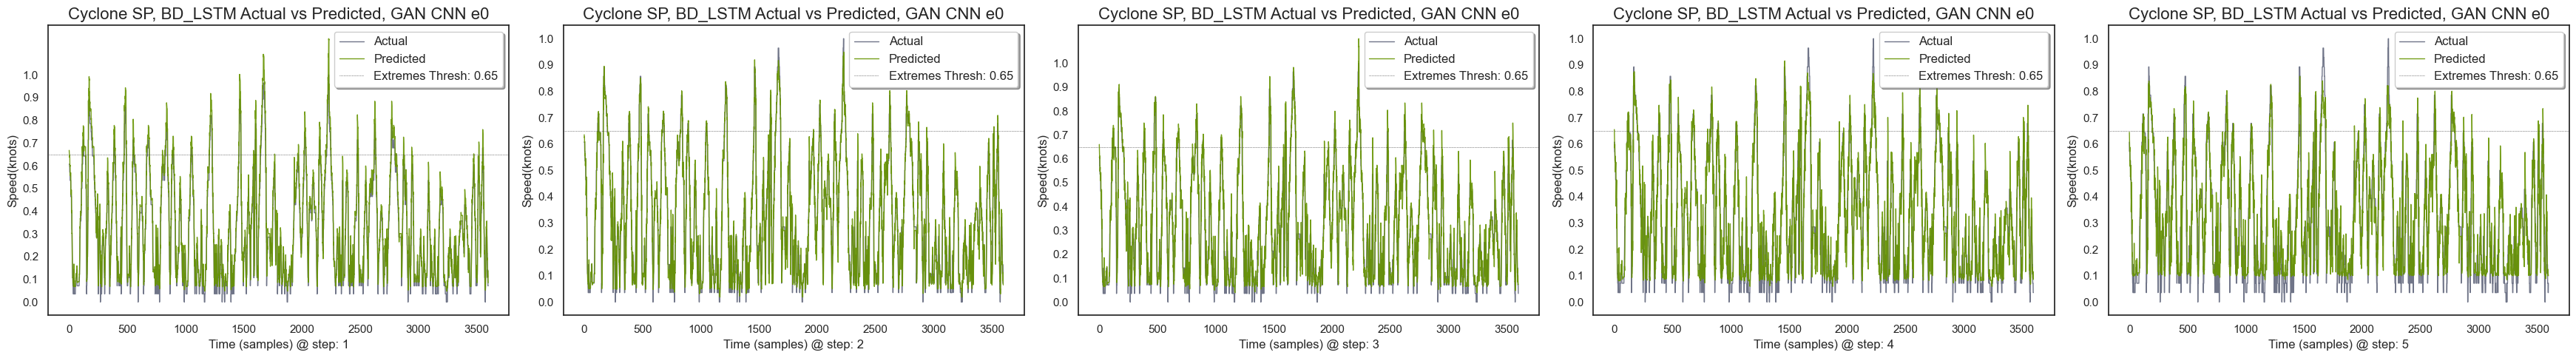

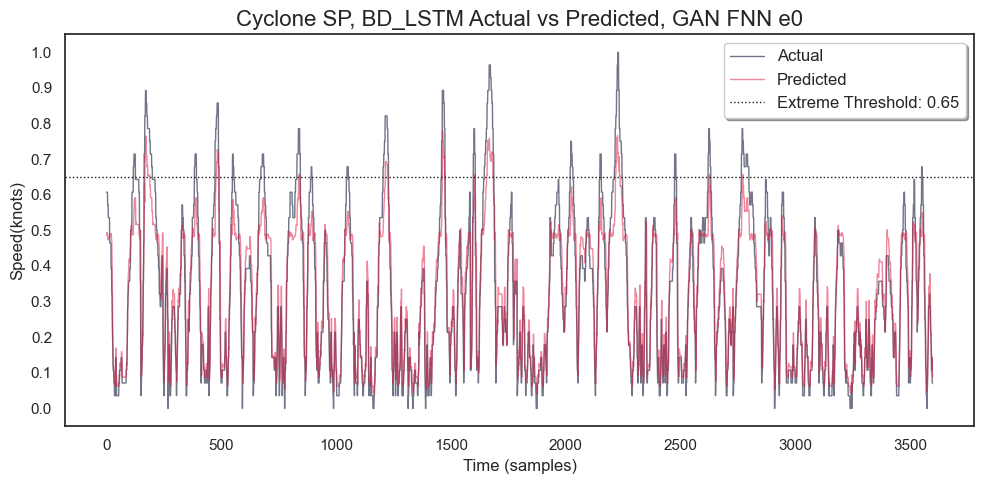

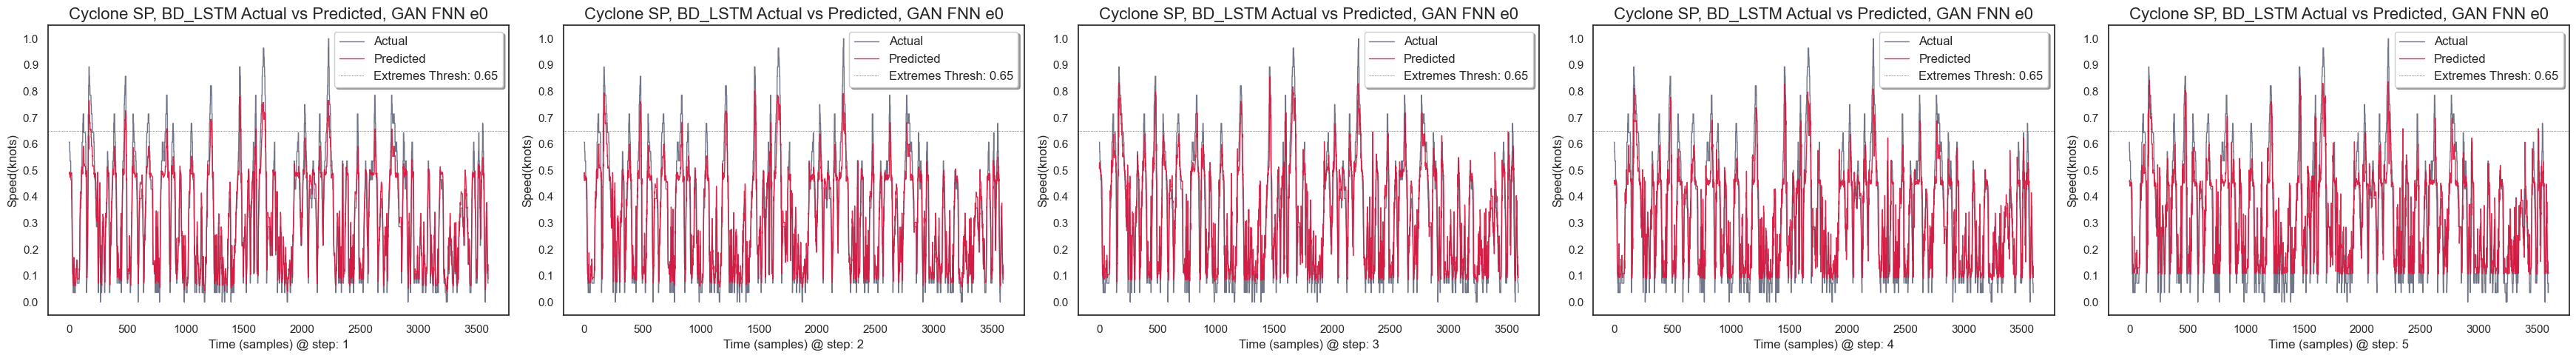

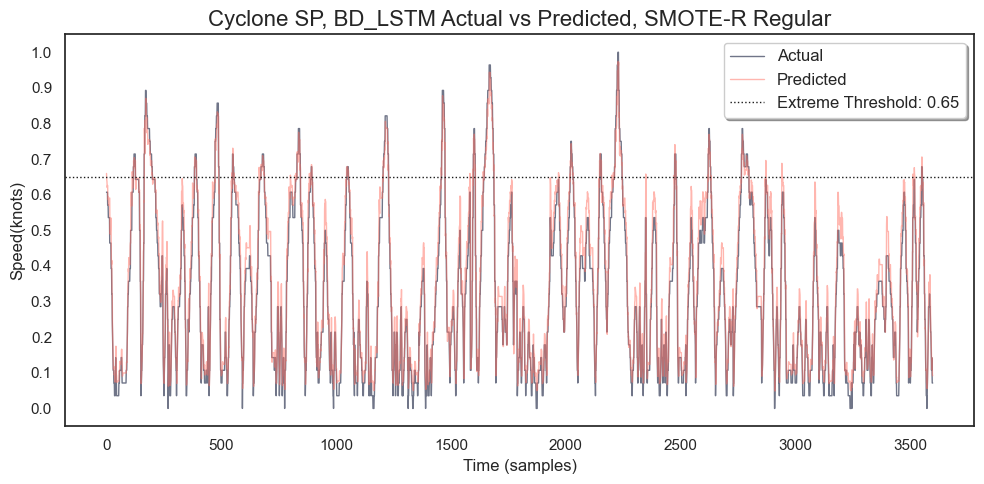

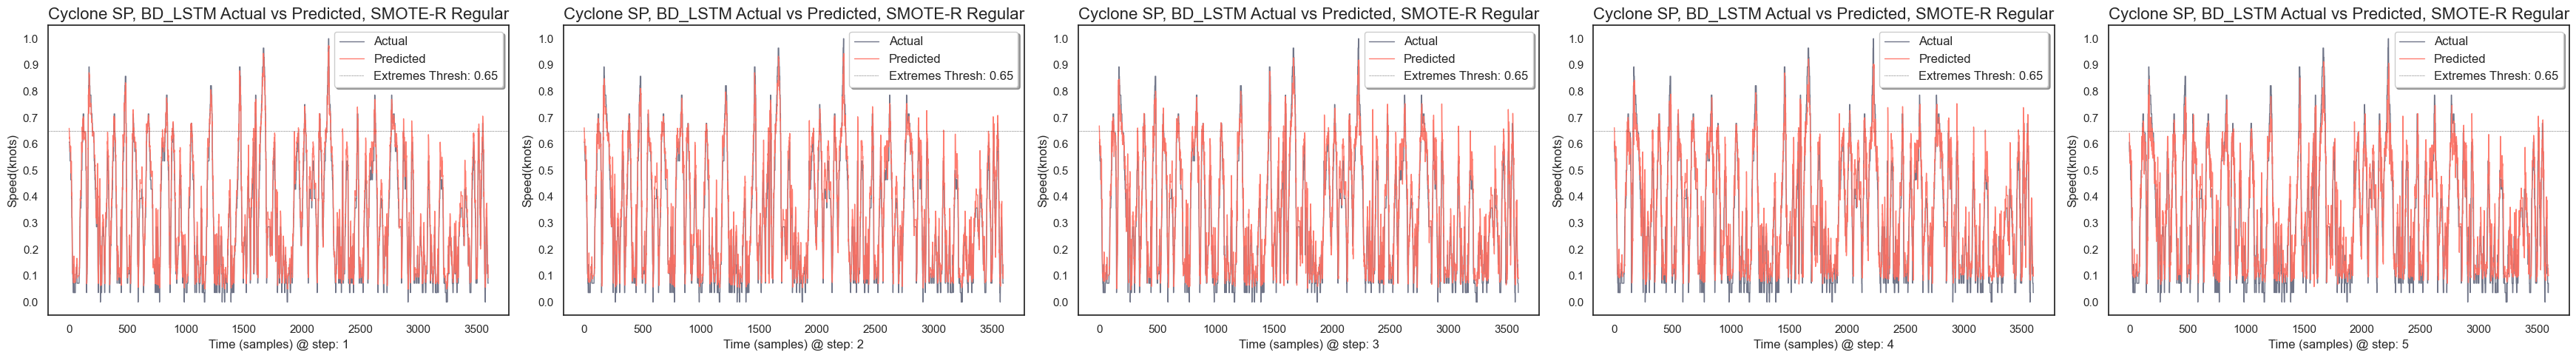

In [23]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
#print(forecast_results)
#PLOT PRED VS ACTUAL + SAVE_EVAL_RESULTS
for f in FORECASTERS:
    for key in forecast_results[f].keys():
        y_predict_test = forecast_results[f][key]['predict_test']
        #Plot a single Actual vs Predicted figure for only one chosen step out: 0 for first step
        pu.PlotPredVsActual1D(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f, 0)
        #Plot a Actual vs Predicted for all steps out in one figure
        pu.PlotPredVsActualSteps(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, N_STEPS_OUT, f)
        #Save forecasting model
        RECORDER.save_LSTM(forecast_results[f][key]['model'], key)
        #TODO: save CNN and LSTM with same function

### Record KS Statistic and Plot Extremes Distribution for Each Resampling Strategy

KS statistic: 0.0832734347103083, p-value: 0.006081034884923965


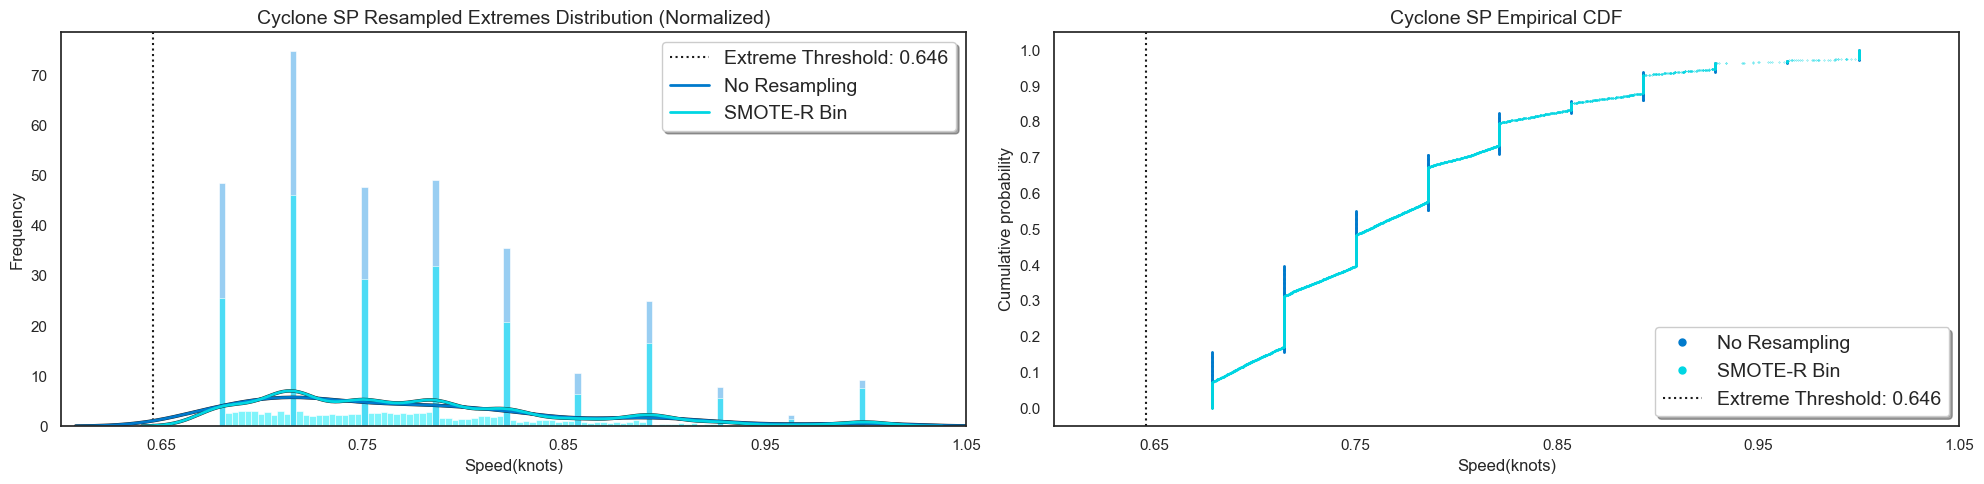

KS statistic: 0.05322529722604389, p-value: 0.1850513249541841


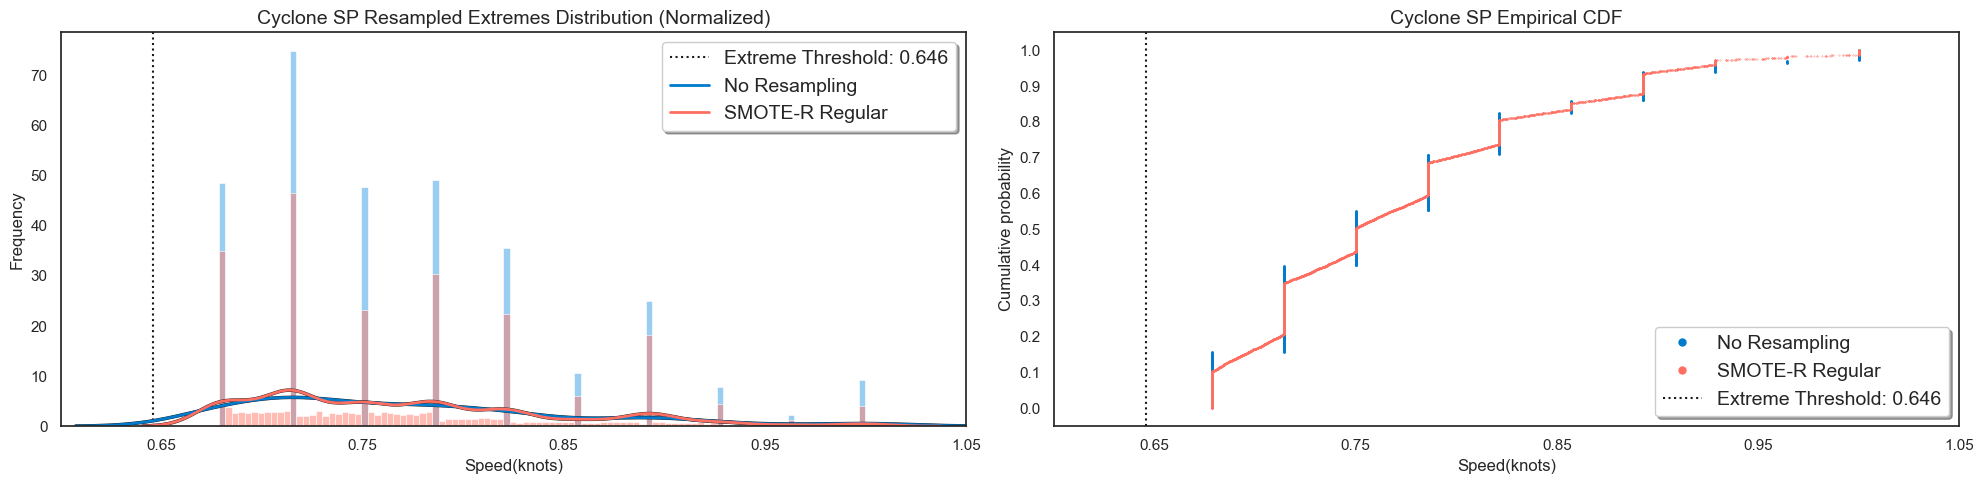

In [13]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
from scipy.stats import ks_2samp
import scipy.stats as stats

step_out = 0
#get extremes for original data
y_orig_rel = RELEVANCE_FUNCTION.__call__(Y_train[:,step_out])
rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_orig_rel]
y_orig_rare = Y_train[rare_mask]
ks_results = []
for key, res in resampling_results.items():
    #get extremes for resampled data
    y_res = res[:,(N_STEPS_IN*N_FVARS):]
    y_rel = RELEVANCE_FUNCTION.__call__(y_res[:,step_out])
    rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_rel]
    y_rare = y_res[rare_mask]

    # Perform the Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(y_orig_rare[:,step_out], y_rare[:,step_out])
    print(f"KS statistic: {statistic}, p-value: {p_value}")
    ks_results.append({'Res':key, 'ksStat':statistic, 'pValue':p_value})
    #Plot extremes hist and cdf for each strategy vs original data
    pu.PlotExremesDistribution(y_orig_rare, y_rare, key, step_out, EXTREMES_THRESHOLD, TVAR, DATA_NAME)
    

ks_df = pd.DataFrame(ks_results)
RECORDER.save_ks(ks_df)

### Prepare Data for Comparison Plots

If we include all strategies on the comparison plots they will be really cluttered and almost useless to the reader. In the following cell we choose the best CNN_GAN, FNN_GAN, and SMOTER_bin approach from the RMSERare of the forecasting results and only include these on the comparison plots. 

Later we'll also use this cell to load the base resampling results / eval metrics to include on the comparison plots along side the next generation of resampling strategies

In [24]:
def calculate_mean(lst):
    return sum(lst) / len(lst)

#Combine EVALER from loaded experiments
#Combine resampling results from loaded experiments
#np.loadtxt('test.txt', delimiter=',', dtype=float)

#TODO: come up with a way to make a copy of evaler so we don't have to filter best strategies for the clustered bar plots

#best_resampling_results will contain best GANs, best SMOTERs
best_resampling_results = resampling_results.copy()
best_cnn_gan = ""
best_fnn_gan = ""
best_bin = ""

def get_best_resampling(forecaster, best, evaler, metric, recorder):
    exp_sum = evaler.getExperimentSummaryDf(metric)
    #get best CNN_GAN if used
    cnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_CNN")]
    if not cnn_exp_sum.empty:
        #apply mean to all rows
        cnn_exp_sum[f"{metric}_Test_Mean"] = cnn_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = cnn_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_cnn_gan = cnn_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best CNN_GAN for {forecaster}: {best_cnn_gan}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "GAN_CNN" in key and key != best_cnn_gan]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['cnn_gan'] = best_cnn_gan
        ekey = int(best_cnn_gan.split('_')[-1][1:])
        recorder.save_gan(CNN_GENS[ekey], CNN_DISCS[ekey], "CNN", best_cnn_gan)
    
    #get best FNN_GAN if used
    fnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_FNN")]
    if not fnn_exp_sum.empty:
        #apply mean to all rows
        fnn_exp_sum[f"{metric}_Test_Mean"] = fnn_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = fnn_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_fnn_gan = fnn_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best FNN_GAN for {forecaster}: {best_fnn_gan}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "GAN_FNN" in key and key != best_fnn_gan]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['fnn_gan'] = best_fnn_gan
        ekey = int(best_fnn_gan.split('_')[-1][1:])
        RECORDER.save_gan(FNN_GENS[ekey], FNN_DISCS[ekey], "FNN", best_fnn_gan)
    #get best SMOTER_bin if used
    bin_exp_sum = exp_sum[exp_sum['Res'].str.contains("SMOTER_bin")] 
    if not bin_exp_sum.empty:
        bin_exp_sum[f"{metric}_Test_Mean"] = bin_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = bin_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_bin = bin_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best SMOTER bin for {forecaster}: {best_bin}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "SMOTER_bin" in key and key != best_bin]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['bin'] = best_bin
    return best #?
                                                         

BEST_RESULTS = {}
for f in FORECASTERS:
    BEST_RESULTS[f] = {'resampling_results': resampling_results.copy(), 'cnn_gan': "", 'fnn_gan': "", "bin": ""}
    #do below stuff with argument 'f'
    BEST_RESULTS[f] = get_best_resampling(f, BEST_RESULTS[f], EVALERS[f], 'RMSERare', RECORDER) #?
    RECORDER.save_resample_results_np(BEST_RESULTS[f]['resampling_results'], f)


#load all resampling results
#COMBINE_RESAMPLING_RESULTS_DIR = Path("Sessions/Bike/2023-October-13 13-41-03-532984").joinpath("resample_results")

#add loaded resampling results to best_resampling_results
#best_resampling_results.update({file.stem: np.loadtxt(file, delimiter=',', dtype=float)
#                  for file in COMBINE_RESAMPLING_RESULTS_DIR.iterdir() if file.is_file()})

Best CNN_GAN for BD_LSTM: GAN_CNN_e0
deleting keys: []
Best FNN_GAN for BD_LSTM: GAN_FNN_e0
deleting keys: []
Best SMOTER bin for BD_LSTM: SMOTER_bin
deleting keys: []


### Compare KDEs and CDFs

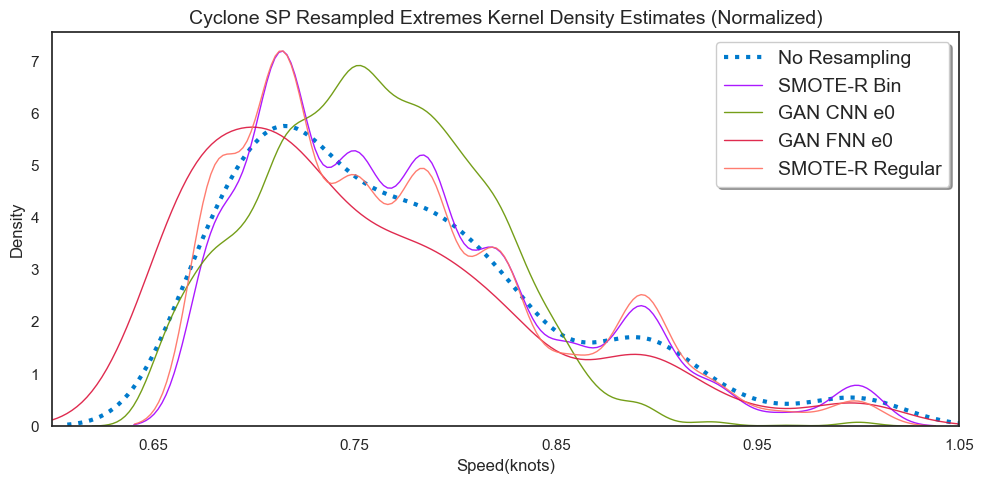

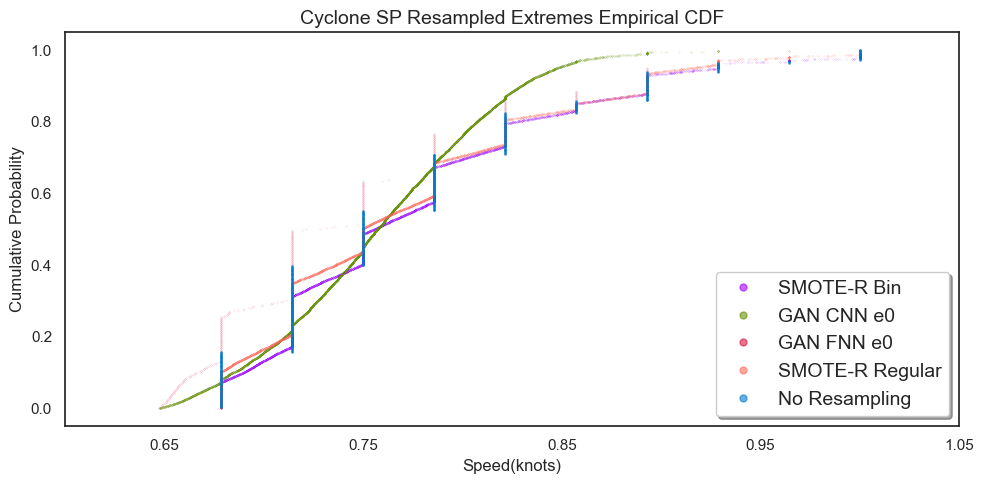

In [25]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
step_out = 0

#compare KDE, CDF
for f in FORECASTERS:
    pu.PlotKDECompare(Y_train, BEST_RESULTS[f]['resampling_results'], RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f)    
    pu.PlotCDFCompare(Y_train, BEST_RESULTS[f]['resampling_results'], RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f)    

### Plot Eval Results Aggregated Over All Steps

1D-GAN


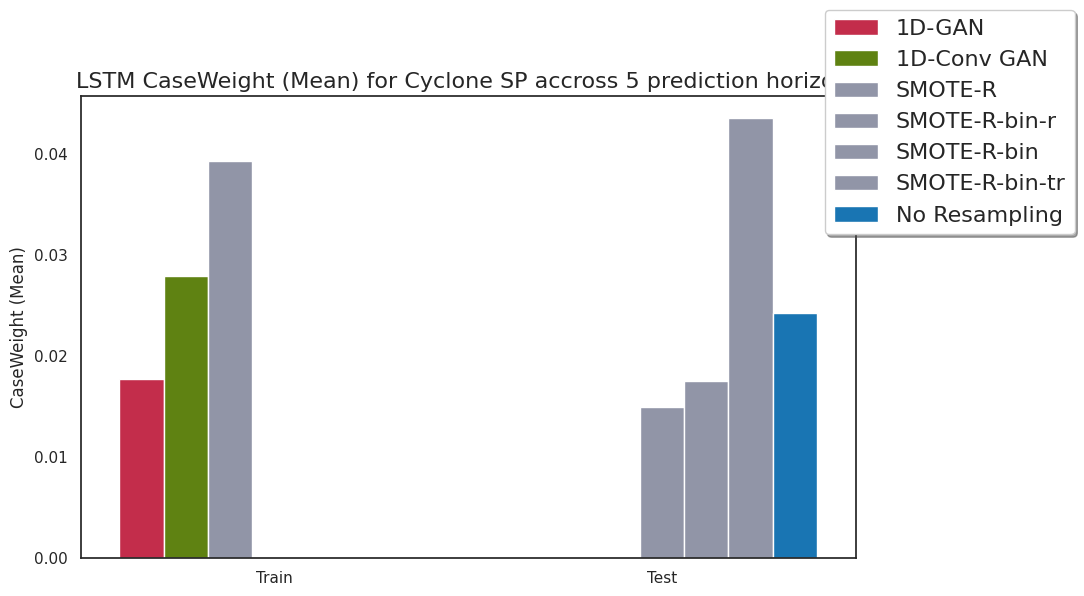

<Figure size 1000x600 with 0 Axes>

1D-GAN


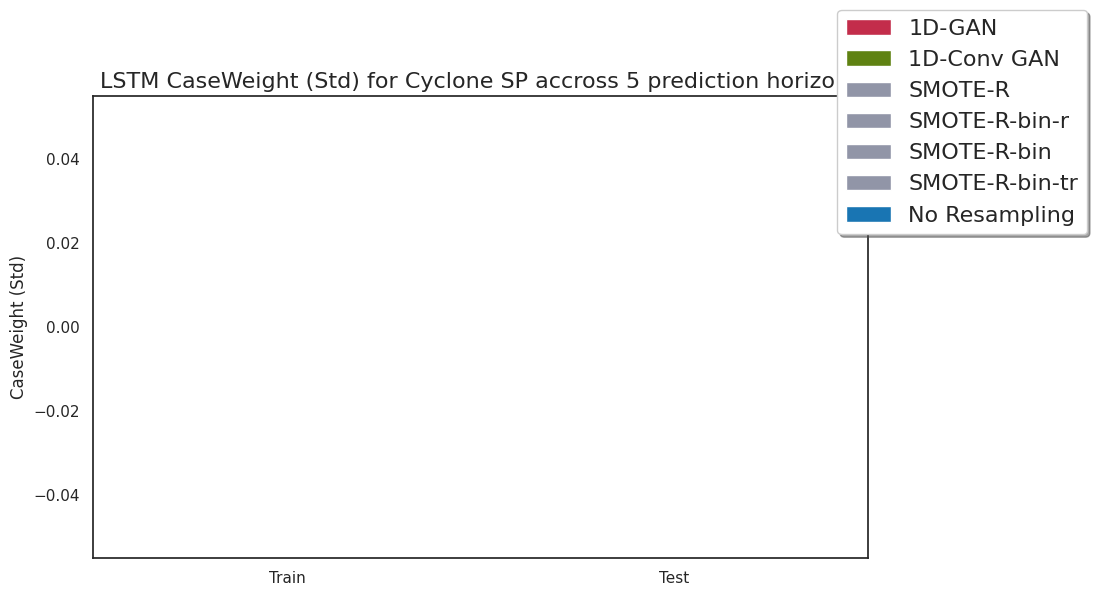

<Figure size 1000x600 with 0 Axes>

1D-GAN


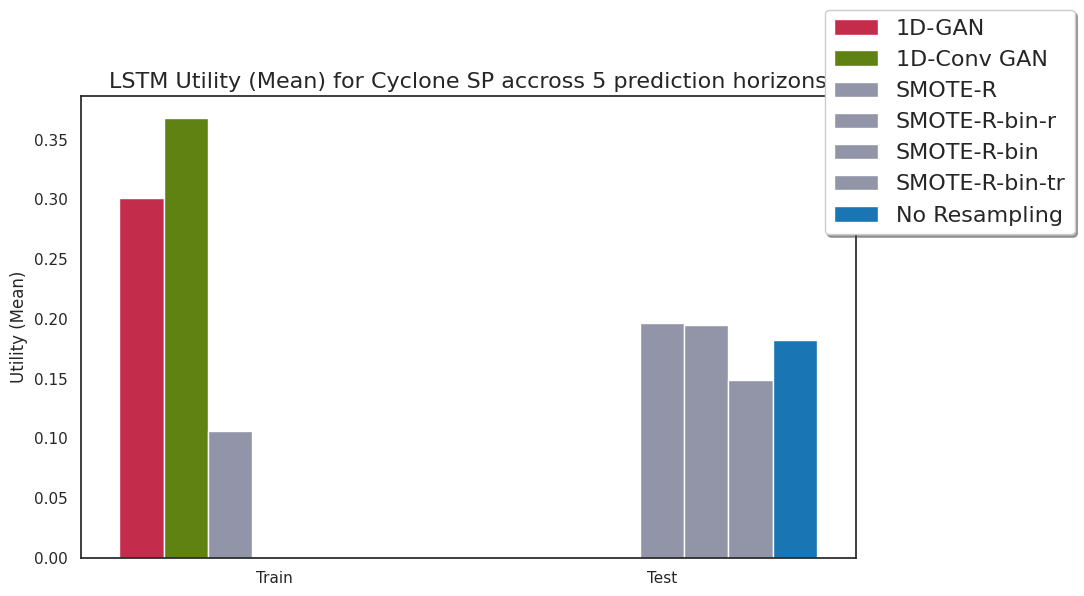

<Figure size 1000x600 with 0 Axes>

1D-GAN


<Figure size 1000x600 with 0 Axes>

1D-GAN


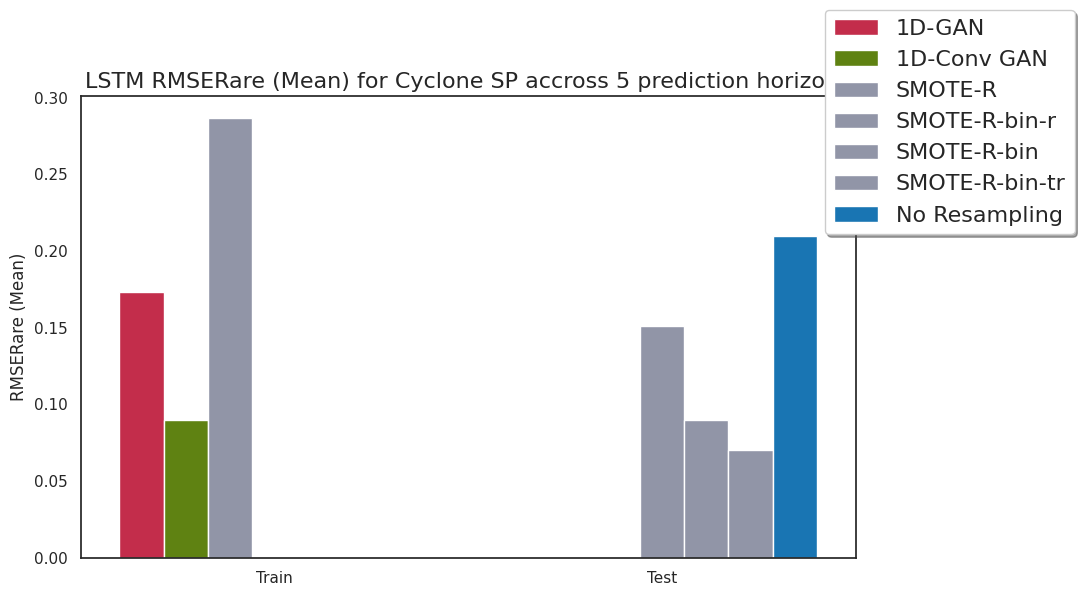

<Figure size 1000x600 with 0 Axes>

1D-GAN


<Figure size 1000x600 with 0 Axes>

1D-GAN


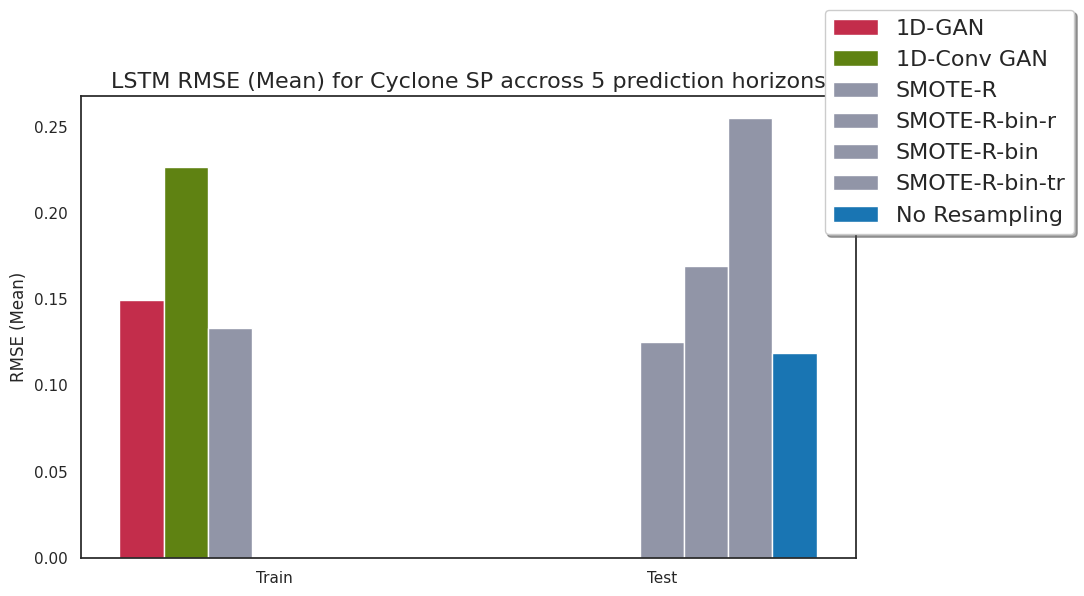

<Figure size 1000x600 with 0 Axes>

1D-GAN


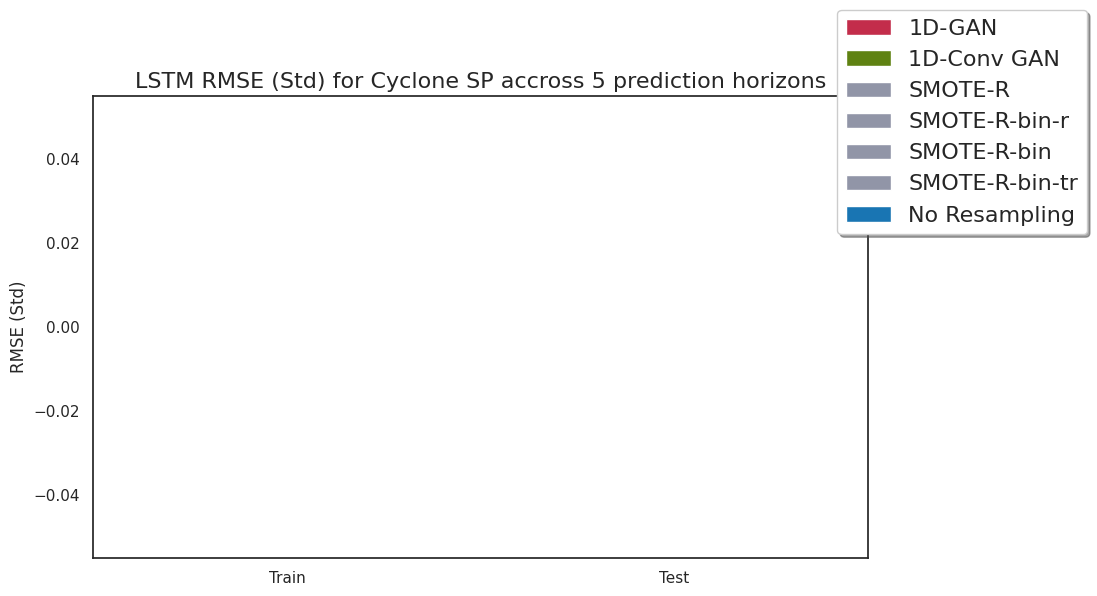

<Figure size 1000x600 with 0 Axes>

1D-GAN


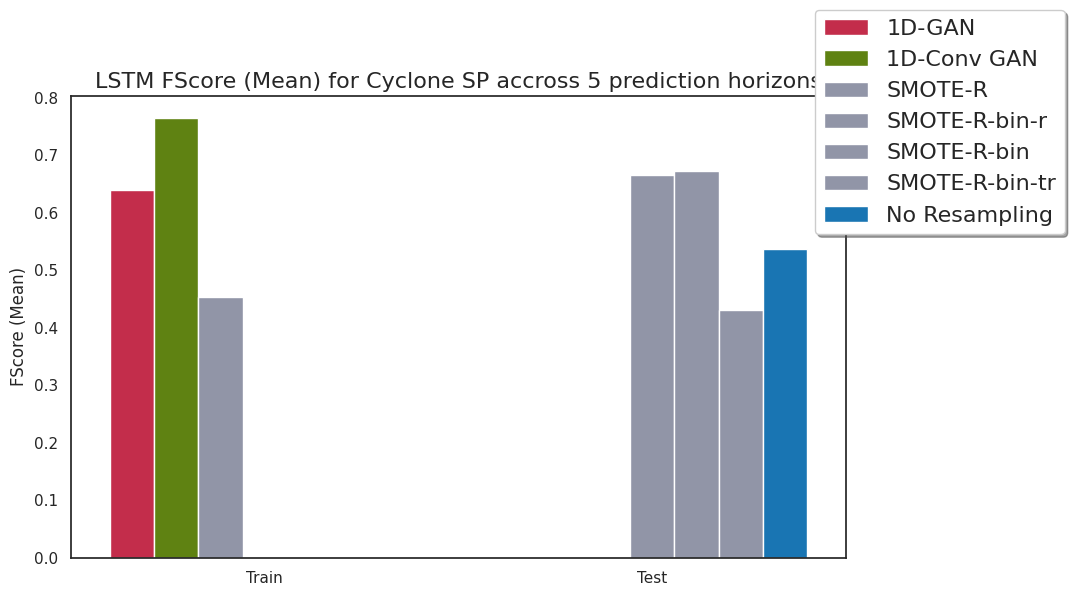

<Figure size 1000x600 with 0 Axes>

1D-GAN


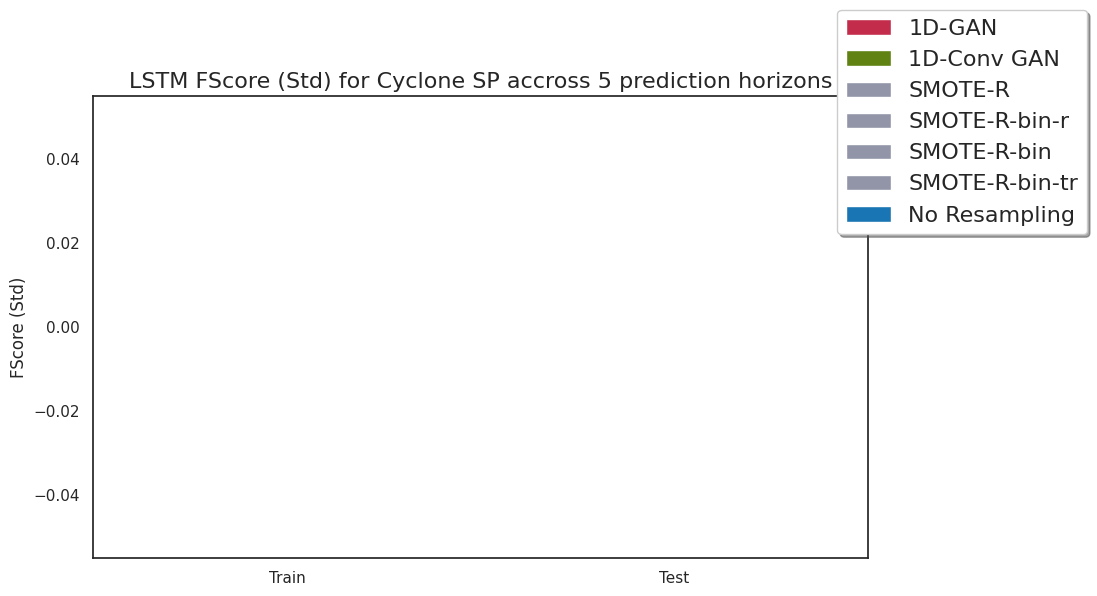

<Figure size 1000x600 with 0 Axes>

1D-GAN


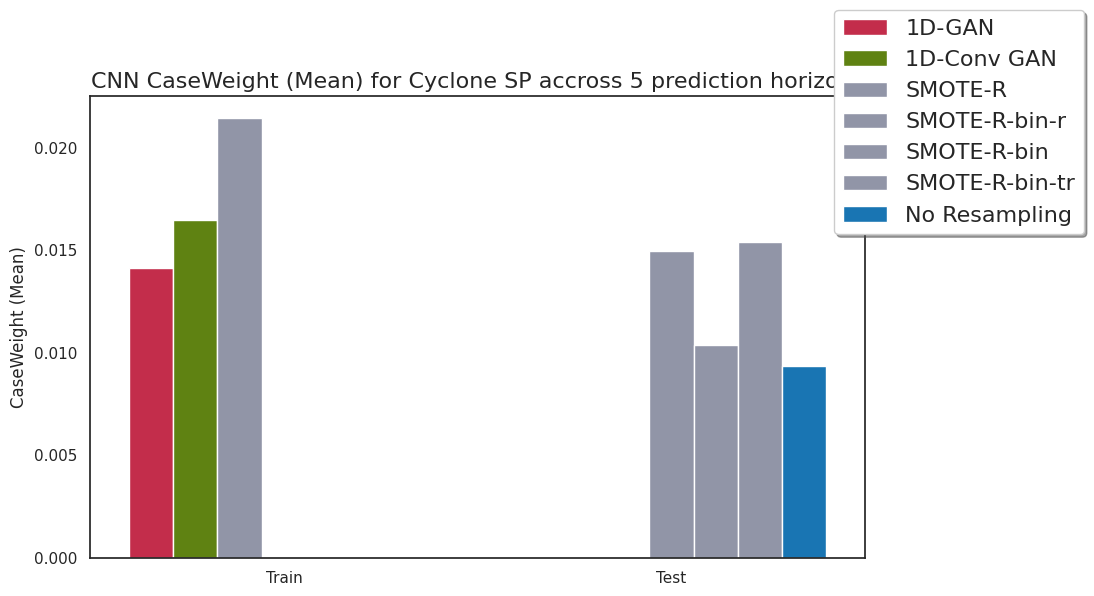

<Figure size 1000x600 with 0 Axes>

1D-GAN


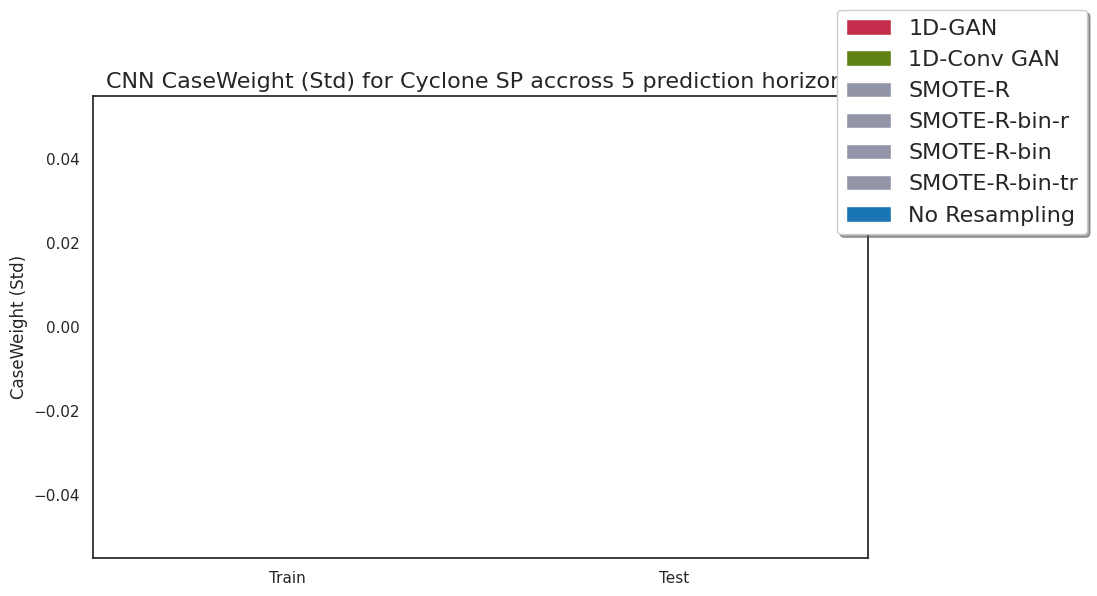

<Figure size 1000x600 with 0 Axes>

1D-GAN


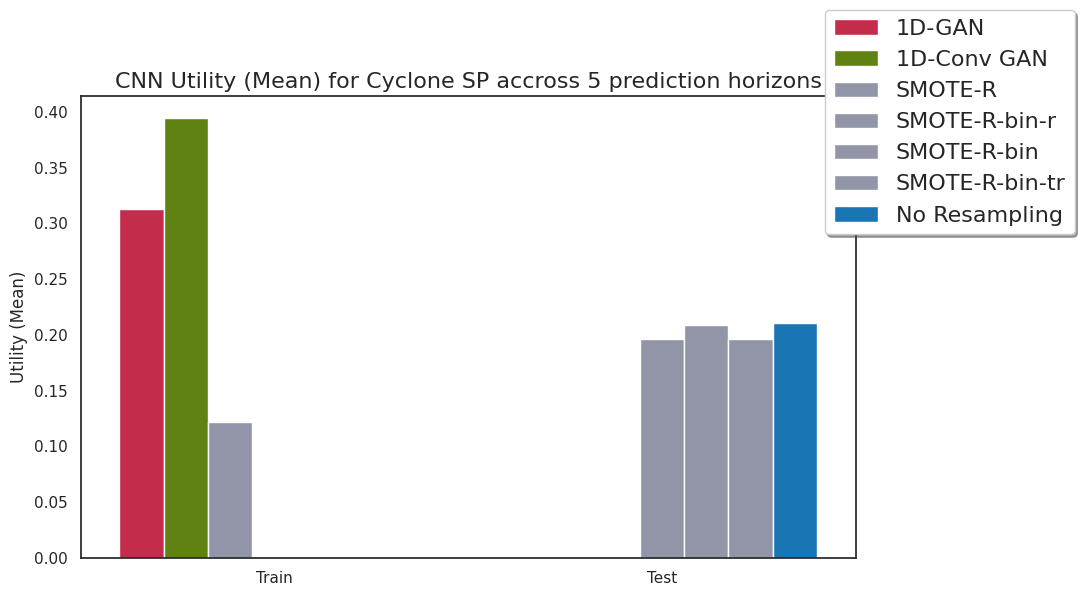

<Figure size 1000x600 with 0 Axes>

1D-GAN


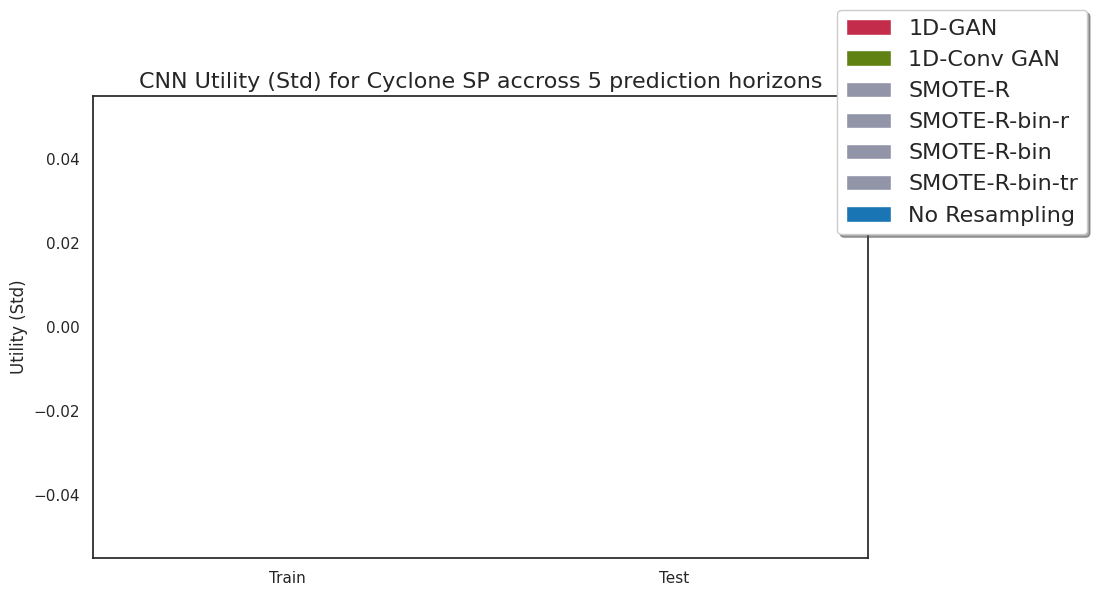

<Figure size 1000x600 with 0 Axes>

1D-GAN


<Figure size 1000x600 with 0 Axes>

1D-GAN


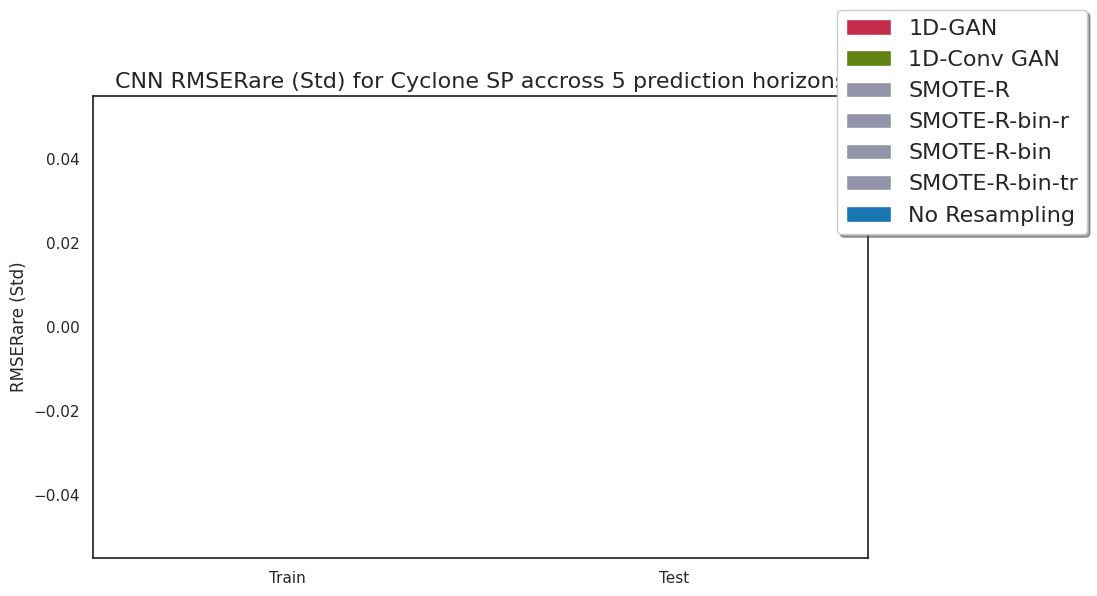

<Figure size 1000x600 with 0 Axes>

1D-GAN


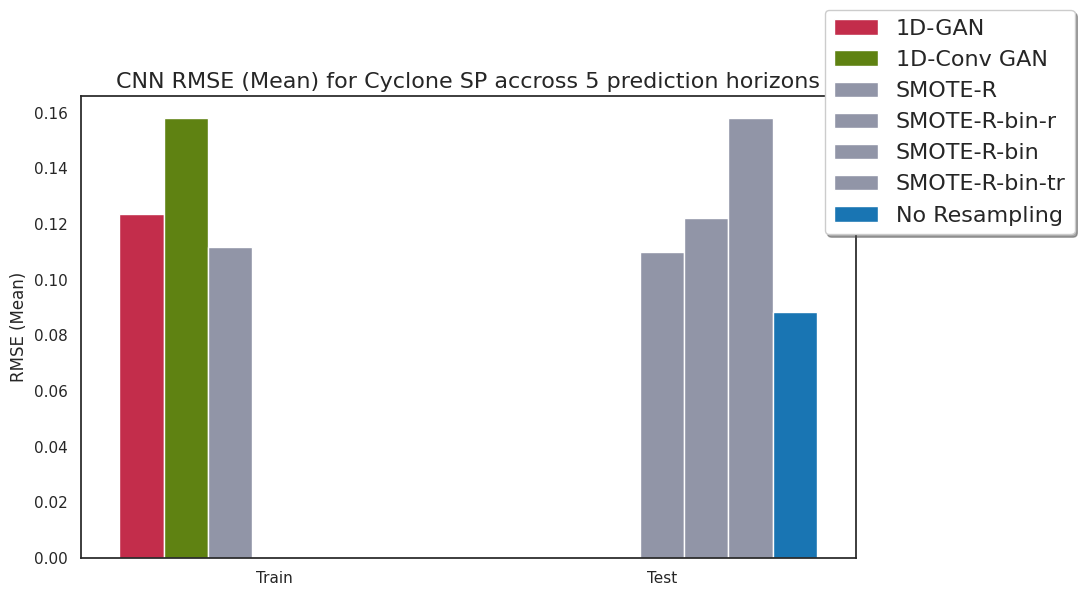

<Figure size 1000x600 with 0 Axes>

1D-GAN


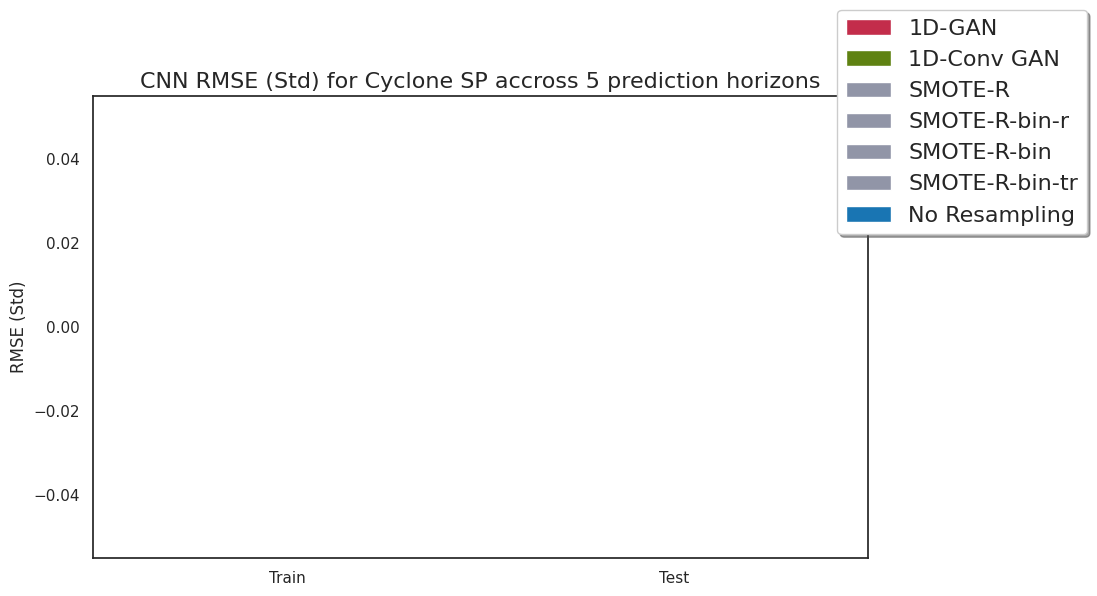

<Figure size 1000x600 with 0 Axes>

1D-GAN


<Figure size 1000x600 with 0 Axes>

1D-GAN


<Figure size 1000x600 with 0 Axes>

In [91]:
#Uncomment if you want to change stuff in plt_utils mid-session
import plt_utils as pu
importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)


def calculate_mean(lst):
    return sum(lst) / len(lst)

#Just plot these metrics:
plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]

ts = ["Train", "Test"] #one cluster for train, one for test results

#aggs options: 
aggs = ["Mean", "Std"]
## for "Mean" we get the mean of the eval metrics over all experiments and plot its average over time steps
## for "Std" we get the std of the eval metrics over all experiments and plot its average over time steps

#for f in FORECASTERS: EVALER[f], get best_cnn_gan, best_fnn_gan, best_bin from dict
#pass an argument to plotting function to specify f
for f in FORECASTERS:
    best_cnn_gan = BEST_RESULTS[f]['cnn_gan']
    best_fnn_gan = BEST_RESULTS[f]['fnn_gan']
    best_bin = BEST_RESULTS[f]['bin']
    for metric in plot_metrics:
        df_results = EVALERS[f].getExperimentSummaryDf(metric, True)
        df_results_train = EVALERS[f].getExperimentSummaryDf(metric, False)
        df_results[f"{metric}_Train_Mean"] = df_results_train[f"{metric}_Train_Mean"]
        df_results[f"{metric}_Train_Std"] = df_results_train[f"{metric}_Train_Std"]
        # Replace with the mean of the steps out lists
        df_results[f"{metric}_Train_Mean"] = df_results[f"{metric}_Train_Mean"].apply(calculate_mean)
        df_results[f"{metric}_Test_Mean"] = df_results[f"{metric}_Test_Mean"].apply(calculate_mean)
        df_results[f"{metric}_Train_Std"] = df_results[f"{metric}_Train_Std"].apply(calculate_mean)
        df_results[f"{metric}_Test_Std"] = df_results[f"{metric}_Test_Std"].apply(calculate_mean)
        for a in aggs:
            #remove any GAN_CNNs, GAN_FNNs, and SMOTER_bin strategies from the dataframe that aren't the best
            filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
            filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
            '''
            filtered_df = df_results
            if best_cnn_gan:
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_CNN')) & (filtered_df['Res'] == best_cnn_gan)) | (~filtered_df['Res'].str.contains('GAN_CNN'))]
            if best_fnn_gan:
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_FNN')) & (filtered_df['Res'] == best_fnn_gan)) | (~filtered_df['Res'].str.contains('GAN_FNN'))]
            '''
            pu.PlotTrainTestBarResults(filtered_df, metric, a, DATA_NAME, N_STEPS_OUT, f)


### Plot Train and Test Eval Results Clustered By Steps Out

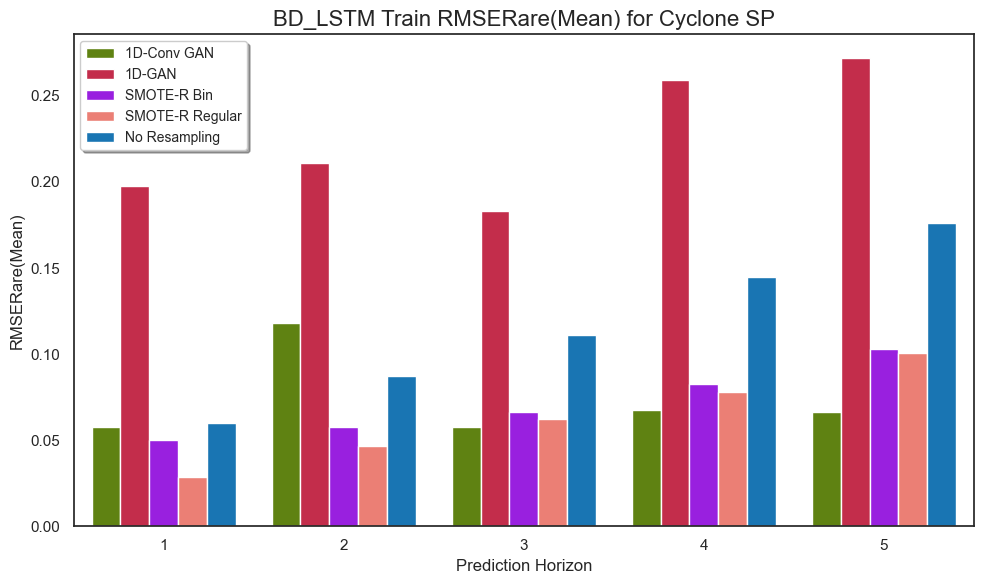

In [29]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)



plot_metrics = ["RMSERare"]#["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]
ts = ["Train", "Test"]
aggs = ["Mean"]#, "Std"]
#either plot mean or std of the experiments
for f in FORECASTERS:
    best_cnn_gan = BEST_RESULTS[f]['cnn_gan']
    best_fnn_gan = BEST_RESULTS[f]['fnn_gan']
    best_bin = BEST_RESULTS[f]['bin']
    for metric in plot_metrics:
        for t in ts:
            tb = True if t == "Test" else False
            df_results = EVALERS[f].getExperimentSummaryDf(metric, tb)
            for a in aggs:
                #filter out all GAN_CNNs, GAN_FNNs or SMOTER_bins that aren't the best
                filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
                #filtered_df = df_results[~df_results['Res'].str.contains('GAN_FNN')]
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
                pu.PlotStepBarResults(filtered_df, metric, a, t, DATA_NAME, N_STEPS_OUT, f)